## Plot results for panels project
- model-predicted panel labels
- NEC calculations for existing loads

In [1]:
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import re
import numpy as np
import math
import random

import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'iframe'

from urllib.request import urlopen
import json
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)


In [34]:
model = "7bins" # <--- "5bins"
if model == "7bins":
    metric_cols = ["<100", "100", "101-124","125", "126-199", "200", "201+"]
elif model == "5bins":
    metric_cols = ["<100", "100", "101-199", "200", "201+"]

main_dir = Path("/Volumes/Lixi_Liu/panels_results_550k")
baseline_file = main_dir / "results_up00.parquet"
model_file = main_dir / "panel_capacity" / f"panel_result__model_{model}__tsv_based__predicted_panels_probablistically_assigned.csv"
model_file_prob = main_dir / "panel_capacity" / f"panel_result__model_{model}__tsv_based__predicted_panels_in_probability.csv"
nec_file = main_dir / "nec_calculations" / "results_up00__res_map__nec_existing_load_exploded.parquet"


### Specify filters to apply to all data

In [3]:
### specify filters as query
has_filter = False # <---

if has_filter:
    filter_query = "`build_existing_model.state` == 'CA' & `build_existing_model.geometry_building_type_recs` == 'Single-Family Detached'" # <---
    folder_ext = "__CA_SFD_only" # <---
    print(f"All input datasets will be filtered using query statement: \n{filter_query}")
else:
    folder_ext = ""
    print("No filter will be applied to the input datasets")

No filter will be applied to the input datasets


In [4]:
output_dir = main_dir / "plots" / f"model_{model}_for_paper{folder_ext}"
output_dir.mkdir(exist_ok=True, parents=True)
print(f"All results will be output to: \n{output_dir}")

All results will be output to: 
/Volumes/Lixi_Liu/panels_results_550k/plots/model_7bins_for_paper


In [25]:
def parse_suffix(file):
    suffixes = file.suffixes
    assert suffixes != [], f"{file=} has no suffixes."
    suffix = "".join(suffixes)
    return suffix

def read_file(file):
    suffix = parse_suffix(file)
    if suffix == ".csv" or suffix == ".csv.gz":
        return pd.read_csv(file, compression="infer", low_memory=False, keep_default_na=False)
    if suffix == ".parquet":
        return pd.read_parquet(file)
    raise ValueError(f"Unsupported {suffix=}")
    
def save_filtered_df_to_file(df, original_filename: Path, output_dir: Path | None):
    new_file = original_filename.stem + "__filtered.csv"
    if output_dir is None:
        new_filename = original_filename.parent / new_file
    else:
        new_filename = output_dir / new_file

    df.to_csv(new_filename, index=False)


In [6]:
def sample_panel_size_unweighted(x):
    """ sample panel size with unweighted (i.e., equally weighted) """
    if x == "<100":
        labels = np.array([30, 60, 70, 90])
        weights = np.ones(len(labels))
    elif x == "101-124":
        labels = np.array([120])
        weights = np.ones(len(labels))
    elif x == "126-199":
        labels = np.array([150, 175])
        weights = np.ones(len(labels))
    elif x == "101-199":
        labels = np.array([120, 125, 150, 175])
        weights = np.ones(len(labels))
    elif x == "201+":
        labels = np.concatenate([
            np.array([225, 250, 275, 300, 325, 350, 375]), 
            np.arange(400, 1100, 100)
        ])
        weights = np.ones(len(labels))
    else:
        return int(x)
    return random.choices(labels, weights=weights, k=1)[0]

# for use with rep value distribution
def weighted_sample(x):
    return random.choices(x[0], weights=x[1], k=1)[0]

def map_lookup_sample(df, lookup):
    # <= 200 amp
    lkup = lookup.loc[lookup["Panel size bin"] != "201+"].set_index(["Panel size bin"])
    elec = df["build_existing_model.heating_fuel"] == "Electricity"
    df.loc[elec, "predicted_panel_amp"] = df.loc[elec, "predicted_panel_amp_bin"].map(lkup["Electric heating fuel"])
    df.loc[~elec, "predicted_panel_amp"] = df.loc[~elec, "predicted_panel_amp_bin"].map(lkup["Non-electric heating fuel"])

    # 201+ amp
    lkup = lookup.loc[lookup["Panel size bin"] == "201+"].set_index(["Floor area"])
    amp201plus = df["predicted_panel_amp_bin"]=="201+"
    df.loc[elec & amp201plus,  "predicted_panel_amp"] = df.loc[elec & amp201plus,  "build_existing_model.geometry_floor_area"].map(
        lkup["Electric heating fuel"]
    )
    df.loc[~elec & amp201plus,  "predicted_panel_amp"] = df.loc[~elec & amp201plus,  "build_existing_model.geometry_floor_area"].map(
        lkup["Non-electric heating fuel"]
    )
    return df
    
    

### Assign value to panel bin labels if missing

In [43]:
### predicted panel sizes
method = "lookup" # <--- unweighted, weighted, lookup (still need to be constructed)

df_baseline = read_file(baseline_file)
df = read_file(model_file)
if not [x for x in df.columns if x.startswith("build_existing_model.")]:
    df = df_baseline.join(df.set_index("building_id"), on="building_id")
if has_filter:
    df = df.query(filter_query).reset_index(drop=True)
    save_filtered_df_to_file(df, model_file, output_dir=output_dir)
    
df["predicted_panel_amp_bin"] = df["predicted_panel_amp_bin"].astype(str)

# sample exact values for panel labels
random.seed(10)
if not "predicted_panel_amp" in df.columns:
    print("No preassigned panel amps, mapping...")
    if method == "unweighted":
        df["predicted_panel_amp"] = df["predicted_panel_amp_bin"].apply(sample_panel_size_unweighted).astype(int)
    elif method == "weighted":
        panel_value_dist = pd.read_csv("model_20240517/weighted_standardized_panel_bin_values.csv").set_index(["panel_amp_pre_bin_7"])["panel_amp_dist"]
        df["predicted_panel_amp"] = df["predicted_panel_amp_bin"].map(panel_value_dist).apply(weighted_sample).astype(int)
    elif method == "lookup":
        lookup = pd.read_csv("model_20240517/panels_bin_lookup_final.csv")
        df = map_lookup_sample(df, lookup)
    else:
        raise NotImplementedError(f"{method=} not implemented")
df

,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,build_existing_model.ahs_region,build_existing_model.aiannh_area,...,report_utility_bills.utility_rates_fixed_variable_total_usd,report_utility_bills.utility_rates_fixed_variable_wood_cord_energy_usd,report_utility_bills.utility_rates_fixed_variable_wood_cord_fixed_usd,report_utility_bills.utility_rates_fixed_variable_wood_cord_total_usd,report_utility_bills.utility_rates_fixed_variable_wood_pellets_energy_usd,report_utility_bills.utility_rates_fixed_variable_wood_pellets_fixed_usd,report_utility_bills.utility_rates_fixed_variable_wood_pellets_total_usd,step_failures,predicted_panel_amp_bin,predicted_panel_amp
0,1,181,2024-08-15 13:45:49,2024-08-15 13:46:10,Success,<NA>,<NA>,,Non-CBSA East South Central,Yes,...,2388.73,0.0,0,0.0,0,0,0,None,200,200
1,2,262,2024-08-16 13:33:53,2024-08-16 13:34:13,Success,<NA>,<NA>,,Non-CBSA New England,No,...,5422.48,326.82,0,326.82,0,0,0,None,<100,60
2,3,262,2024-08-16 14:17:45,2024-08-16 14:18:08,Success,<NA>,<NA>,,"CBSA Boston-Cambridge-Newton, MA-NH",No,...,2464.49,0.0,0,0.0,0,0,0,None,100,100
3,4,102,2024-08-15 06:32:40,2024-08-15 06:32:59,Success,<NA>,<NA>,,Non-CBSA West South Central,No,...,2649.14,0.0,0,0.0,0,0,0,None,200,200
4,5,28,2024-08-14 17:54:32,2024-08-14 17:54:56,Success,<NA>,<NA>,,"CBSA Riverside-San Bernardino-Ontario, CA",No,...,2507.5,0.0,0,0.0,0,0,0,None,200,200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
483058,549995,288,2024-08-15 18:34:05,2024-08-15 18:34:36,Success,<NA>,<NA>,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",No,...,2643.2,0.0,0,0.0,0,0,0,None,200,200
483059,549996,201,2024-08-16 08:01:45,2024-08-16 08:02:16,Success,<NA>,<NA>,,Non-CBSA South Atlantic,No,...,2979.78,0.0,0,0.0,0,0,0,None,200,200
483060,549997,267,2024-08-16 14:10:45,2024-08-16 14:11:13,Success,<NA>,<NA>,,Non-CBSA Middle Atlantic,No,...,4099.49,1108.46,0,1108.46,0,0,0,None,100,100
483061,549998,129,2024-08-15 08:33:08,2024-08-15 08:33:35,Success,<NA>,<NA>,,"CBSA Los Angeles-Long Beach-Anaheim, CA",No,...,1967.96,0.0,0,0.0,0,0,0,None,100,100


In [44]:
df["predicted_panel_amp_bin"] = pd.Categorical(df["predicted_panel_amp_bin"], ordered=True, categories=metric_cols)

# load prediction in probabilities
dfm = read_file(model_file_prob)
if has_filter:
    if not [x for x in dfm.columns if x.startswith("build_existing_model.")]:
        dfm = df_baseline.join(dfm.set_index("building_id"), on="building_id")
    dfm = dfm.query(filter_query).reset_index(drop=True)
    save_filtered_df_to_file(dfm, model_file_prob, output_dir=output_dir)
    
dfm = df.join(dfm.set_index("building_id")[metric_cols], on="building_id")
del df

# occupied only
dfm = dfm.loc[dfm["build_existing_model.vacancy_status"]=="Occupied"].reset_index(drop=True)
dfm

,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,build_existing_model.ahs_region,build_existing_model.aiannh_area,...,step_failures,predicted_panel_amp_bin,predicted_panel_amp,<100,100,101-124,125,126-199,200,201+
0,1,181,2024-08-15 13:45:49,2024-08-15 13:46:10,Success,<NA>,<NA>,,Non-CBSA East South Central,Yes,...,None,200,200,0.004376,0.025145,0.001621,0.015369,0.004582,0.919393,0.029514
1,2,262,2024-08-16 13:33:53,2024-08-16 13:34:13,Success,<NA>,<NA>,,Non-CBSA New England,No,...,None,<100,60,0.014458,0.547731,0.002360,0.119583,0.017033,0.282907,0.015926
2,3,262,2024-08-16 14:17:45,2024-08-16 14:18:08,Success,<NA>,<NA>,,"CBSA Boston-Cambridge-Newton, MA-NH",No,...,None,100,100,0.159568,0.484735,0.001733,0.166111,0.047494,0.073933,0.066425
3,4,102,2024-08-15 06:32:40,2024-08-15 06:32:59,Success,<NA>,<NA>,,Non-CBSA West South Central,No,...,None,200,200,0.073138,0.253399,0.001286,0.106491,0.028595,0.510522,0.026569
4,5,28,2024-08-14 17:54:32,2024-08-14 17:54:56,Success,<NA>,<NA>,,"CBSA Riverside-San Bernardino-Ontario, CA",No,...,None,200,200,0.040686,0.452232,0.002675,0.161170,0.029616,0.298037,0.015583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
483058,549995,288,2024-08-15 18:34:05,2024-08-15 18:34:36,Success,<NA>,<NA>,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",No,...,None,200,200,0.009847,0.746199,0.002532,0.043968,0.016354,0.160201,0.020899
483059,549996,201,2024-08-16 08:01:45,2024-08-16 08:02:16,Success,<NA>,<NA>,,Non-CBSA South Atlantic,No,...,None,200,200,0.008764,0.050361,0.008597,0.028233,0.017243,0.865030,0.021772
483060,549997,267,2024-08-16 14:10:45,2024-08-16 14:11:13,Success,<NA>,<NA>,,Non-CBSA Middle Atlantic,No,...,None,100,100,0.006292,0.446271,0.007461,0.078571,0.034957,0.391617,0.034830
483061,549998,129,2024-08-15 08:33:08,2024-08-15 08:33:35,Success,<NA>,<NA>,,"CBSA Los Angeles-Long Beach-Anaheim, CA",No,...,None,100,100,0.006046,0.052494,0.002240,0.024850,0.022883,0.882563,0.008924


In [29]:
### NEC calc of existing loads
dfn = read_file(nec_file)
if not [x for x in dfn.columns if x.startswith("build_existing_model.")]:
    dfn = df_baseline.join(dfn.set_index("building_id"), on="building_id")
    del df_baseline
if has_filter:
    dfn = dfn.query(filter_query).reset_index(drop=True)
    save_filtered_df_to_file(dfn, nec_file, output_dir=output_dir)

# occupied only
dfn = dfn.loc[dfn["build_existing_model.vacancy_status"]=="Occupied"].reset_index(drop=True)
dfn["amp_total_pre_upgrade_A_220_83"] = dfn["amp_total_pre_upgrade_A_220_83"].astype(float)
dfn["amp_total_pre_upgrade_A_220_87"] = dfn["amp_total_pre_upgrade_A_220_87"].astype(float)
dfn

,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,build_existing_model.ahs_region,build_existing_model.aiannh_area,...,load_laundry,load_washer,load_dishwasher,load_garbage_disposal,load_well_pump,load_pool_pump,load_total_pre_upgrade_VA_220_83,amp_total_pre_upgrade_A_220_83,load_total_pre_upgrade_VA_220_87,amp_total_pre_upgrade_A_220_87
0,1,181,2024-08-15 13:45:49,2024-08-15 13:46:10,Success,<NA>,<NA>,,Non-CBSA East South Central,Yes,...,1500,0,0.0,0.0,0.0,0.0,21821.347958,90.922283,17386.750,72.444792
1,2,262,2024-08-16 13:33:53,2024-08-16 13:34:13,Success,<NA>,<NA>,,Non-CBSA New England,No,...,1500,0,0.0,0.0,0.0,0.0,11248.351760,46.868132,4765.375,19.855729
2,3,262,2024-08-16 14:17:45,2024-08-16 14:18:08,Success,<NA>,<NA>,,"CBSA Boston-Cambridge-Newton, MA-NH",No,...,1500,0,1200.0,0.0,0.0,0.0,13286.071920,55.358633,6757.125,28.154688
3,4,102,2024-08-15 06:32:40,2024-08-15 06:32:59,Success,<NA>,<NA>,,Non-CBSA West South Central,No,...,1500,0,0.0,0.0,0.0,0.0,14918.904720,62.162103,7315.500,30.481250
4,5,28,2024-08-14 17:54:32,2024-08-14 17:54:56,Success,<NA>,<NA>,,"CBSA Riverside-San Bernardino-Ontario, CA",No,...,1500,0,0.0,0.0,0.0,0.0,9191.614080,38.298392,5209.125,21.704687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
483058,549995,288,2024-08-15 18:34:05,2024-08-15 18:34:36,Success,<NA>,<NA>,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",No,...,1500,0,0.0,0.0,0.0,0.0,11497.951600,47.908132,9687.750,40.365625
483059,549996,201,2024-08-16 08:01:45,2024-08-16 08:02:16,Success,<NA>,<NA>,,Non-CBSA South Atlantic,No,...,1500,0,0.0,0.0,0.0,746.0,24691.624748,102.881770,17549.500,73.122917
483060,549997,267,2024-08-16 14:10:45,2024-08-16 14:11:13,Success,<NA>,<NA>,,Non-CBSA Middle Atlantic,No,...,1500,0,1200.0,0.0,0.0,746.0,17109.701600,71.290423,13581.500,56.589583
483061,549998,129,2024-08-15 08:33:08,2024-08-15 08:33:35,Success,<NA>,<NA>,,"CBSA Los Angeles-Long Beach-Anaheim, CA",No,...,1500,0,1200.0,0.0,0.0,0.0,16854.852908,70.228554,6418.875,26.745313


### plot funcs

In [30]:
def extract_left_edge(val):
    # for sorting things like AMI
    if val is None:
        return np.nan
    if not isinstance(val, str):
        return val
    first = val[0]
    if re.search(r"\d", val) or first in ["<", ">"] or first.isdigit():
        vals = [int(x) for x in re.split("\-| |\%|\<|\+|\>|s|th|p|A|B|C| ", val) if re.match("\d", x)]
        if len(vals) > 0:
            num = vals[0]
            if "<" in val:
                num -= 1
            if ">" in val:
                num += 1
            return num
    return val
    
def sort_index(df, axis="index", **kwargs):
    """ axis: ['index', 'columns'] """
    if axis in [0, "index"]:
        try:
            df = df.reindex(sorted(df.index, key=extract_left_edge, **kwargs))
        except TypeError:
            df = df.reindex(sorted(df.index, **kwargs))
        return df

    if axis in [1, "columns"]:
        col_index_name = df.columns.name
        try:
            cols = sorted(df.columns, key=extract_left_edge, **kwargs)
        except TypeError:
            cols = sorted(df.columns, **kwargs)
        df = df[cols]
        df.columns.name = col_index_name
        return df
    raise ValueError(f"axis={axis} is invalid")

def format_labels(lst):
    flst = []
    for idx in lst:
        if len(idx)/15 > 1:
            size = math.ceil(len(idx) / 2)
            part1 = idx[:size]
            part2 = idx[size:]
            
            for i in range(1, len(part1)+1):
                if part1[-i] == " ":
                    break
            
            for j in range(len(part2)):
                if part2[j] == " ":
                    break
                    
            if i > j:
                k = len(part1)+j
            else:
                k = len(part1)-i
            
            flst.append(idx[:k]+"\n"+idx[k+1:])
        else:
            flst.append(idx)
    return flst

### plots

In [31]:
### make categories for plotting
dfm["build_existing_model.vintage"] = pd.Categorical(dfm["build_existing_model.vintage"], ordered=True, 
        categories=['<1940', '1940s', '1950s', '1960s', '1970s', '1980s', '1990s', '2000s','2010s'])
dfm["build_existing_model.vintage_acs"] = pd.Categorical(dfm["build_existing_model.vintage_acs"], ordered=True, 
        categories=['<1940', '1940-59', '1960-79', '1980-99', '2000-09', '2010s'])
dfm["build_existing_model.geometry_floor_area"] = pd.Categorical(dfm["build_existing_model.geometry_floor_area"], ordered=True, 
        categories=['0-499', '500-749', '750-999', '1000-1499', '1500-1999', '2000-2499', '2500-2999', '3000-3999', '4000+'])
dfm["build_existing_model.geometry_floor_area_bin"] = pd.Categorical(dfm["build_existing_model.geometry_floor_area_bin"], ordered=True, 
        categories=['0-1499', '1500-2499', '2500-3999', '4000+'])
dfm["build_existing_model.federal_poverty_level"] = pd.Categorical(dfm["build_existing_model.federal_poverty_level"], ordered=True, 
        categories=['0-100%', '100-150%', '150-200%', '200-300%', '300-400%', '400%+'])
dfm["build_existing_model.area_median_income"] = pd.Categorical(dfm["build_existing_model.area_median_income"], ordered=True, 
        categories=['0-30%', '30-60%', '60-80%', '80-100%', '100-120%', '120-150%', '150%+'])

### [1] plot probability of labels by one variable

no plot for build_existing_model.state...


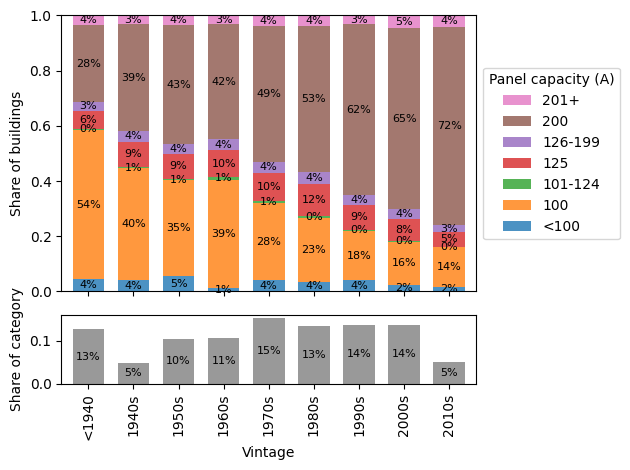

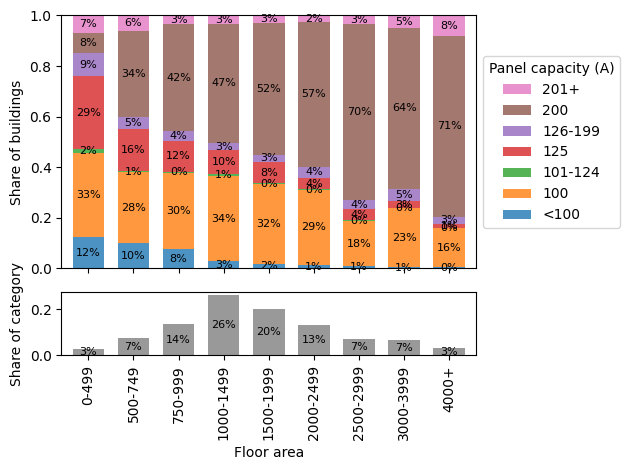

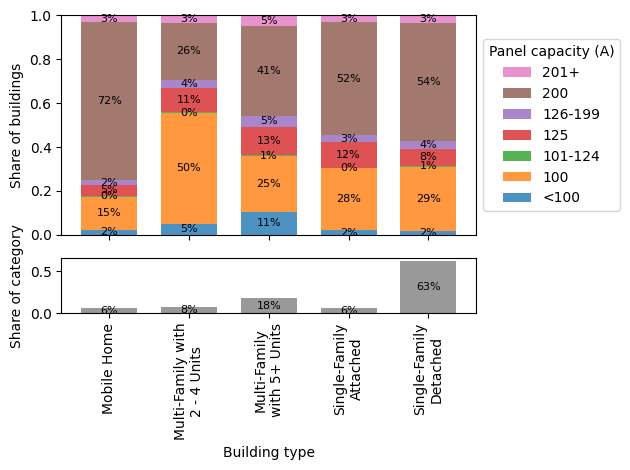

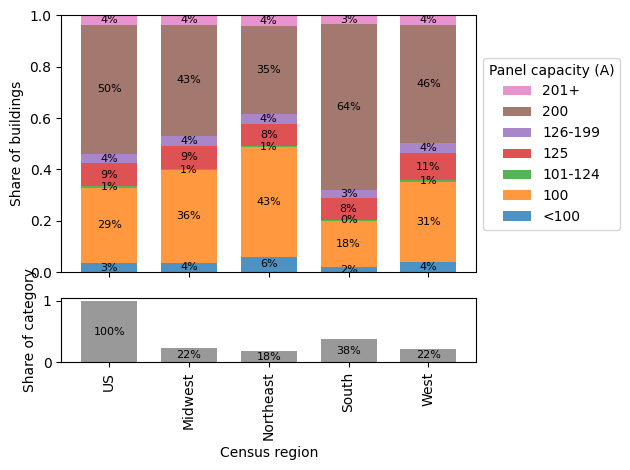

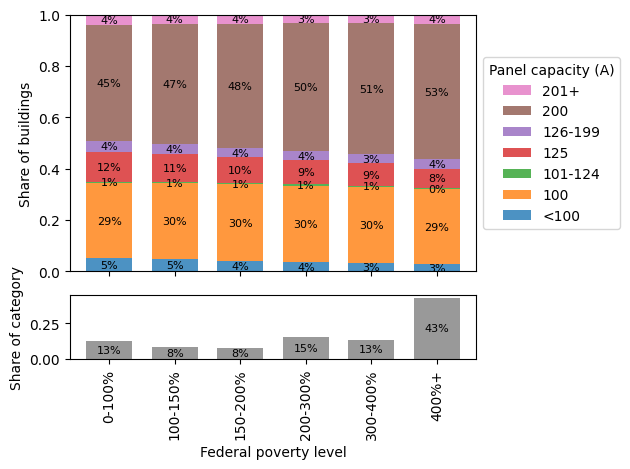

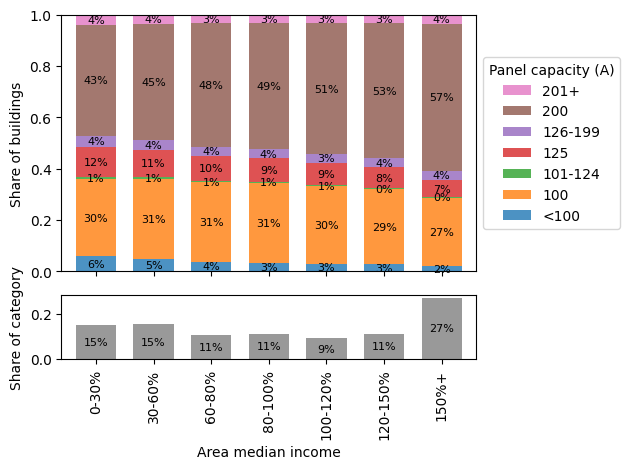

In [33]:
groupby_cols = [
    "build_existing_model.state",
    "build_existing_model.vintage",
    "build_existing_model.geometry_floor_area",
    "build_existing_model.geometry_building_type_recs",
    "build_existing_model.census_region", 
    "build_existing_model.federal_poverty_level",
    "build_existing_model.area_median_income",
]
x_labels = [
    "State",
    "Vintage",
    "Floor area",
    "Building type",
    "Census region", # include additional col for US
    "Federal poverty level",
    "Area median income",
]

for gbc, xlab in zip(groupby_cols, x_labels):
    dfi = dfm.groupby(gbc)[metric_cols].sum()
    dfc = dfm.groupby(gbc)["building_id"].count()
    
    dfi = dfi.divide(dfi.sum(axis=1), axis=0)
    dfi = sort_index(sort_index(dfi, axis=0), axis=1)
    dfc = sort_index(dfc.divide(dfc.sum()))
    
    if gbc == "build_existing_model.census_region":
        # add US total to data
        us = (dfm[metric_cols].sum() / dfm[metric_cols].sum().sum()).rename("US")
        dfi = pd.concat([us, dfi.T], axis=1).T
        dfi.index.name = gbc

        dfc = pd.concat([pd.Series(1, index=["US"]), dfc], axis=0)
        dfc.index.name = gbc

    if gbc == "build_existing_model.state":
        print(f"no plot for {gbc}...")
        pass
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, gridspec_kw={'height_ratios': [4,1]})
        dfi.plot(kind="bar", stacked=True,  alpha=0.8, width=0.7, ax=ax1)
        ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5), reverse=True, title="Panel capacity (A)")
        ax1.set_ylim(0,1)
        ax1.set_ylabel(f"Share of buildings")
    
        for i, row in dfi.reset_index(drop=True).iterrows():
            for j in range(len(row)):
                ax1.text(i, row.iloc[0:j].sum()+row.iloc[j]/2, f"{row.iloc[j]*100:.0f}%", ha="center", va="center", fontsize=8)
    
        dfc.plot(kind="bar", stacked=False, color="gray", alpha=0.8, width=0.7, ax=ax2)
        ax2.set_xticks(ticks = range(len(dfc)), labels = format_labels(dfc.index))
        ax2.set_xlabel(xlab)
        ax2.set_ylabel("Share of category")
    
        for j in range(len(dfc)):
            ax2.text(j, dfc.iloc[j]/2, f"{dfc.iloc[j]*100:.0f}%", ha="center", va="center", fontsize=8)
    
        plt.tight_layout()
        
        metric = f"label_proba_by_{xlab}"
        fig.savefig(output_dir / f"stacked_bar__{metric}.png", dpi=400, bbox_inches="tight")
        dfi.to_csv(output_dir / f"data__stacked_bar__{metric}.csv", index=True)

### [1.1] plot probability of labels by one variable - CA only

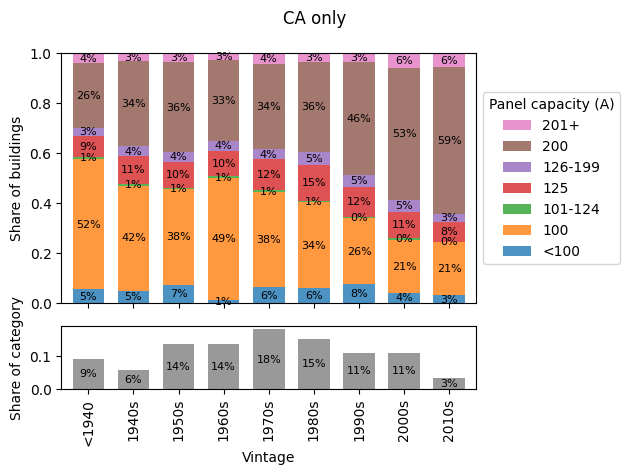

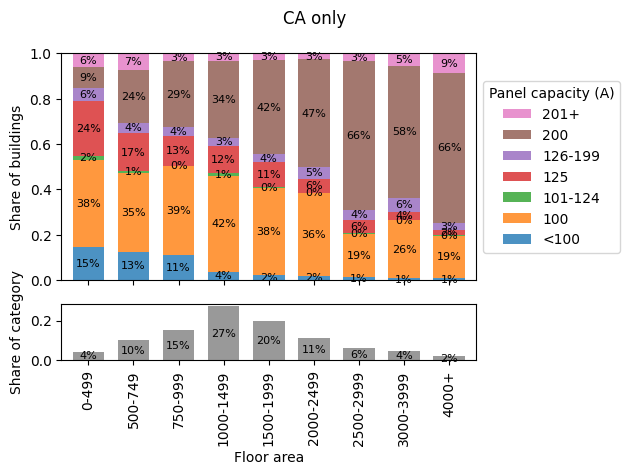

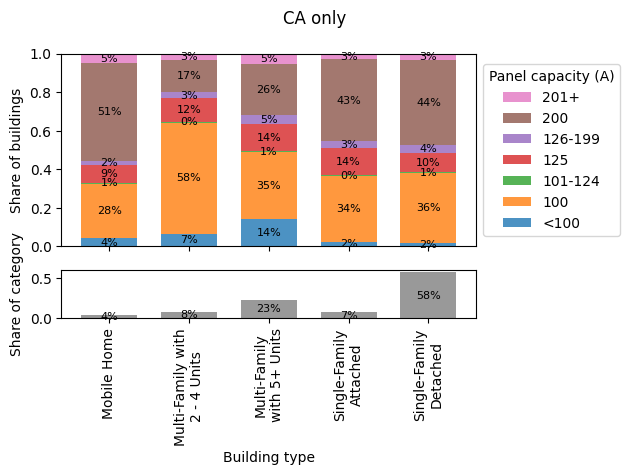

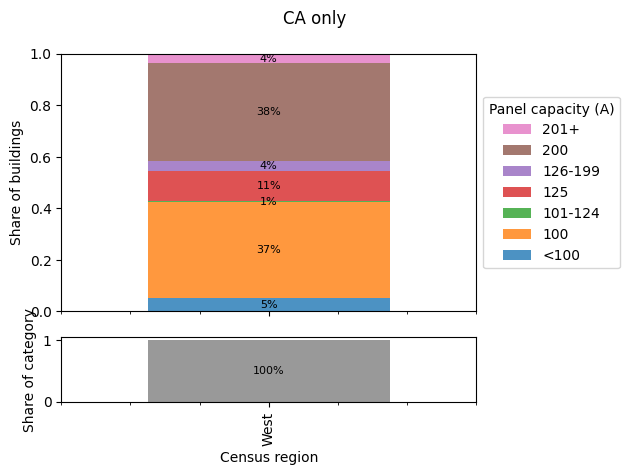

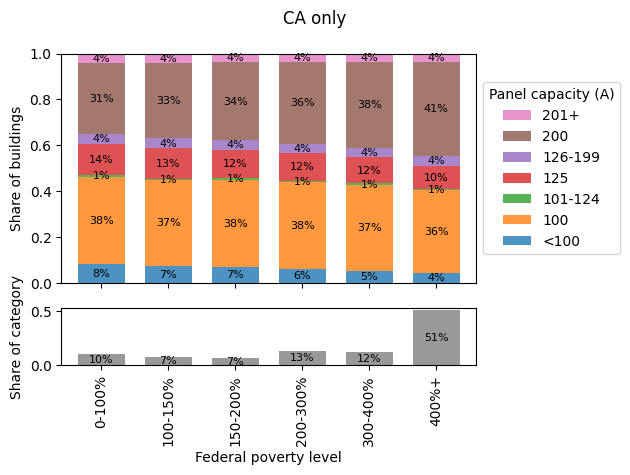

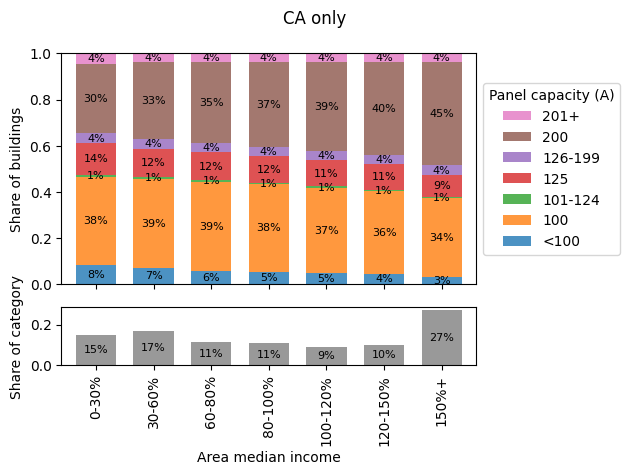

In [35]:
if not has_filter:
    state = "CA" # <---
    cond = dfm["build_existing_model.state"]==state

    #########################################
    groupby_cols = [
        "build_existing_model.vintage",
        "build_existing_model.geometry_floor_area",
        "build_existing_model.geometry_building_type_recs",
        "build_existing_model.census_region", 
        "build_existing_model.federal_poverty_level",
        "build_existing_model.area_median_income",
    ]
    x_labels = [
        "Vintage",
        "Floor area",
        "Building type",
        "Census region",
        "Federal poverty level",
        "Area median income",
    ]

    for gbc, xlab in zip(groupby_cols, x_labels):
        dfi = dfm.loc[cond].groupby(gbc)[metric_cols].sum()
        dfc = dfm.loc[cond].groupby(gbc)["building_id"].count()
        
        dfi = dfi.divide(dfi.sum(axis=1), axis=0)
        dfi = sort_index(sort_index(dfi, axis=0), axis=1)
        dfc = sort_index(dfc.divide(dfc.sum()))
        
        fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, gridspec_kw={'height_ratios': [4,1]})
        dfi.plot(kind="bar", stacked=True,  alpha=0.8, width=0.7, ax=ax1)
        ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5), reverse=True, title="Panel capacity (A)")
        ax1.set_ylim(0,1)
        ax1.set_ylabel(f"Share of buildings")

        for i, row in dfi.reset_index(drop=True).iterrows():
            for j in range(len(row)):
                ax1.text(i, row.iloc[0:j].sum()+row.iloc[j]/2, f"{row.iloc[j]*100:.0f}%", ha="center", va="center", fontsize=8)

        dfc.plot(kind="bar", stacked=False, color="gray", alpha=0.8, width=0.7, ax=ax2)
        ax2.set_xticks(ticks = range(len(dfc)), labels = format_labels(dfc.index))
        ax2.set_xlabel(xlab)
        ax2.set_ylabel("Share of category")

        for j in range(len(dfc)):
            ax2.text(j, dfc.iloc[j]/2, f"{dfc.iloc[j]*100:.0f}%", ha="center", va="center", fontsize=8)

        fig.suptitle(f"{state} only")
        plt.tight_layout()
        
        metric = f"label_proba_by_{xlab}"
        fig.savefig(output_dir / f"CA_only__stacked_bar__{metric}.png", dpi=400, bbox_inches="tight")
        dfi.to_csv(output_dir / f"CA_only__data__stacked_bar__{metric}.csv", index=True)

### [2] plot probability of labels by two variables

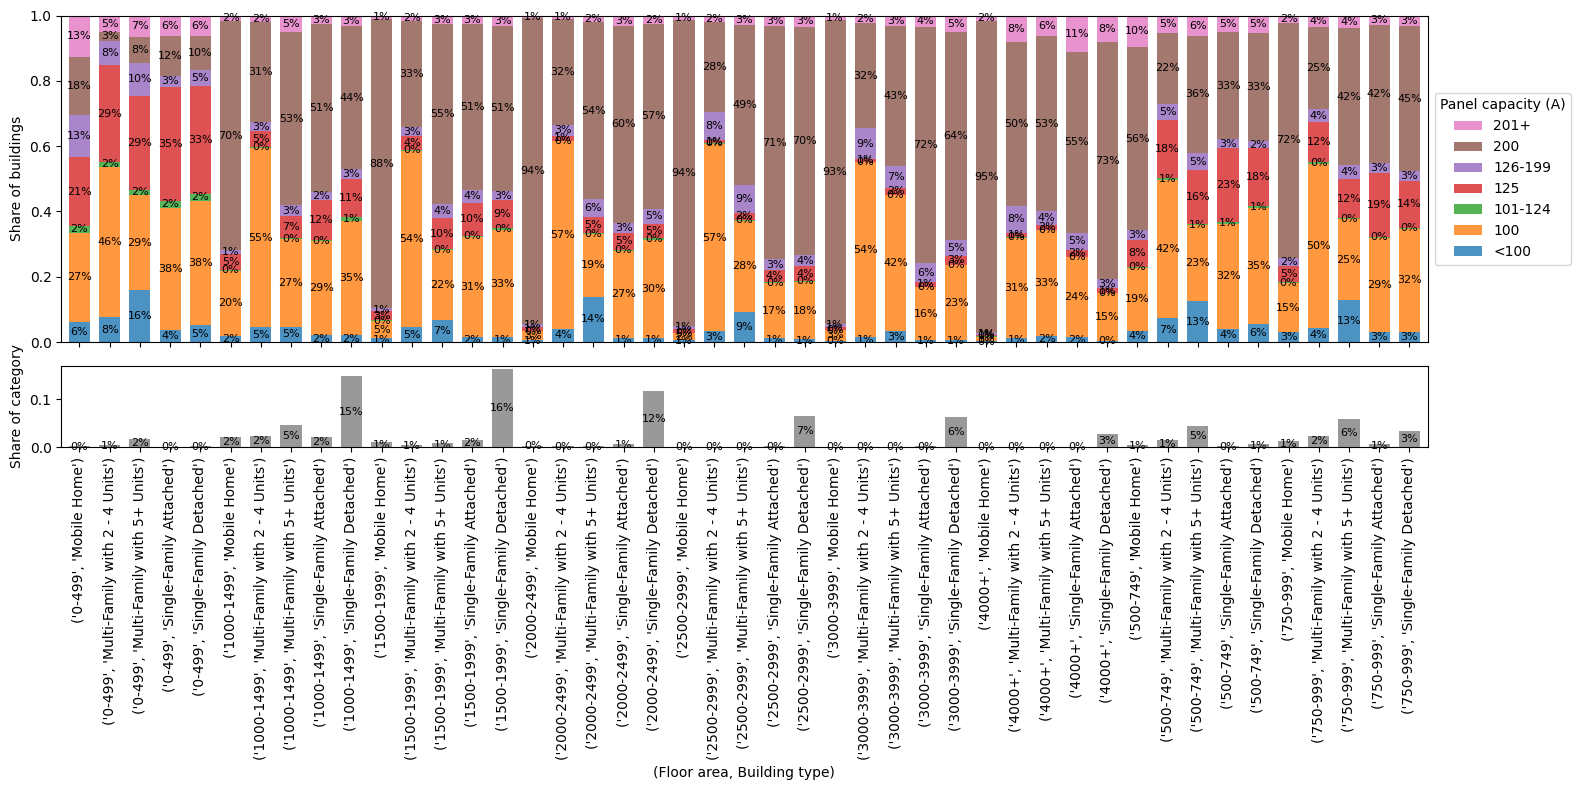

In [36]:
### alternative

gbc = ["build_existing_model.geometry_floor_area", "build_existing_model.geometry_building_type_recs"]
xlab = "(Floor area, Building type)"

dfi = dfm.groupby(gbc)[metric_cols].sum()
dfc = dfm.groupby(gbc)["building_id"].count()

dfi = dfi.divide(dfi.sum(axis=1), axis=0)
dfc = sort_index(dfc.divide(dfc.sum()))
dfi = sort_index(sort_index(dfi, axis=0), axis=1)

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, gridspec_kw={'height_ratios': [4,1]}, figsize=(16,8))
dfi.plot(kind="bar", stacked=True,  alpha=0.8, width=0.7, ax=ax1)
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5), reverse=True, title="Panel capacity (A)")
ax1.set_ylim(0,1)
ax1.set_ylabel(f"Share of buildings")

for i, row in dfi.reset_index(drop=True).iterrows():
    for j in range(len(row)):
        ax1.text(i, row.iloc[0:j].sum()+row.iloc[j]/2, f"{row.iloc[j]*100:.0f}%", ha="center", va="center", fontsize=8)

dfc.plot(kind="bar", stacked=False, color="gray", alpha=0.8, width=0.7, ax=ax2)
ax2.set_xticks(ticks = range(len(dfc)), labels = format_labels(dfc.index))
ax2.set_xlabel(xlab)
ax2.set_ylabel("Share of category")

for j in range(len(dfc)):
    ax2.text(j, dfc.iloc[j]/2, f"{dfc.iloc[j]*100:.0f}%", ha="center", va="center", fontsize=8)

plt.tight_layout()

metric = f"label_proba_by_{xlab}"
fig.savefig(output_dir / f"3stacked_bar__{metric}.png", dpi=400, bbox_inches="tight")


### [2.1] plot probability of labels by one variable, subplot by Census Region

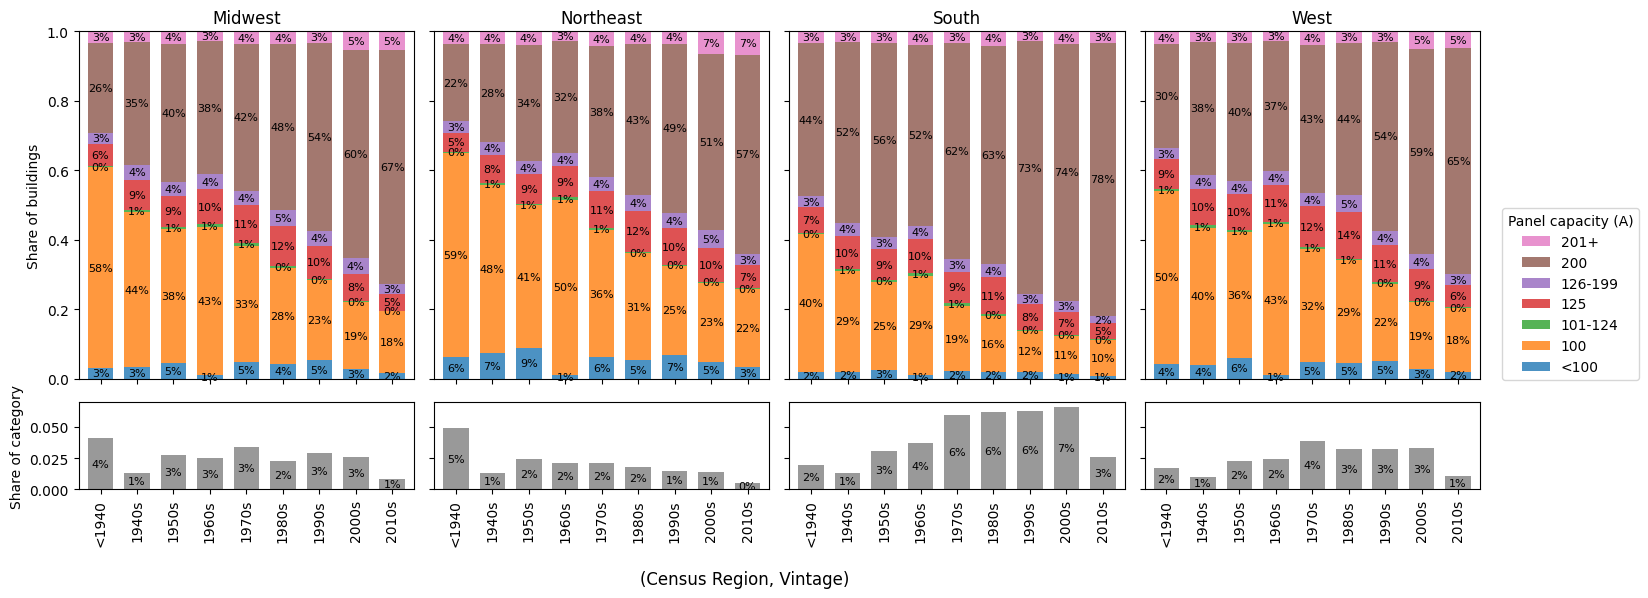

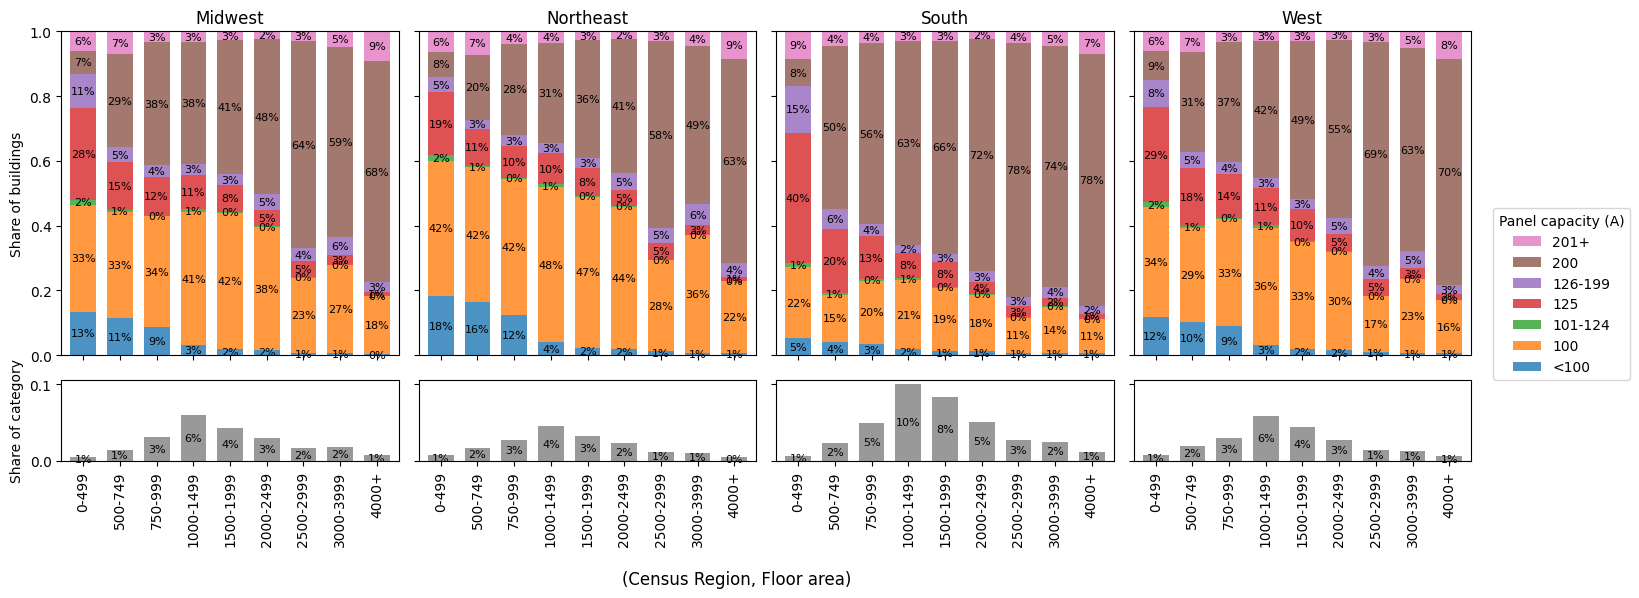

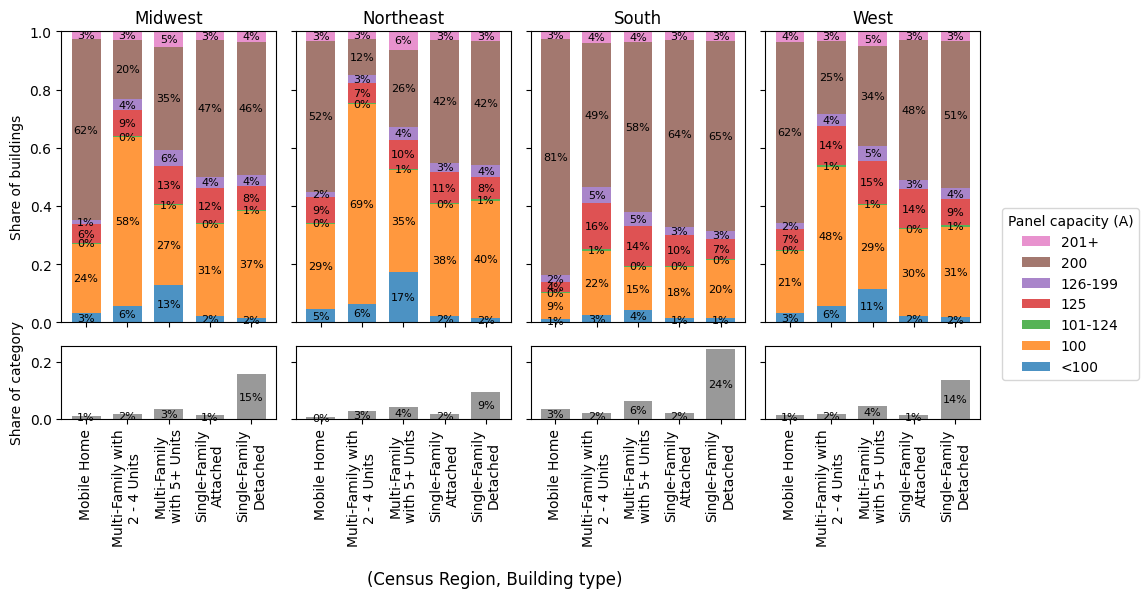

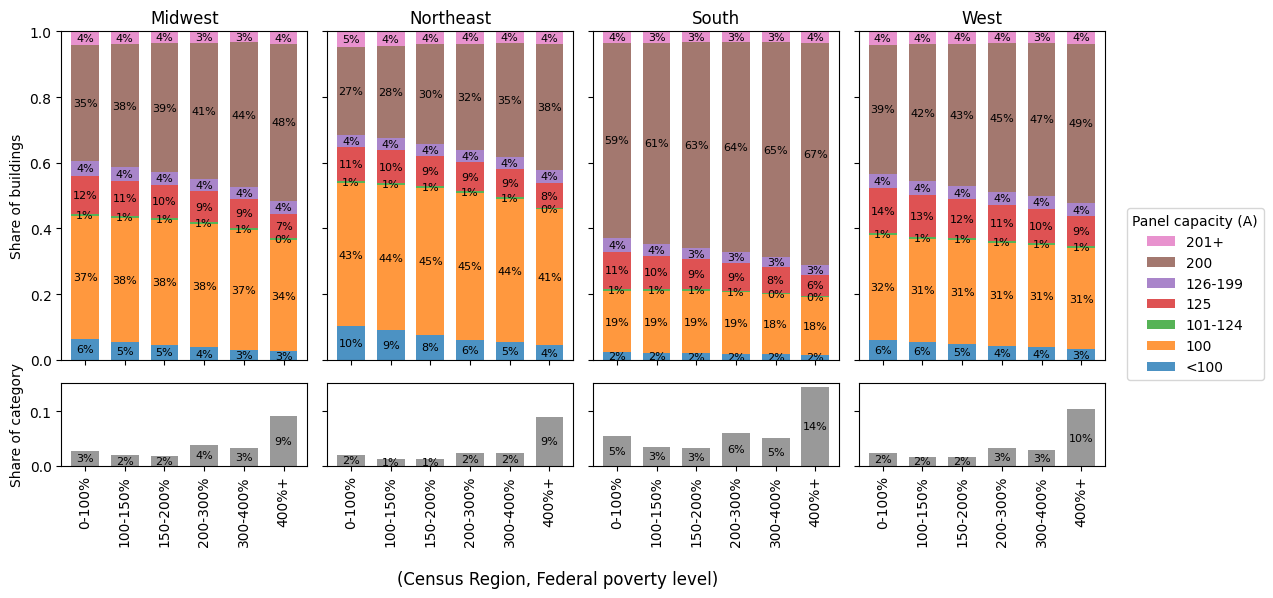

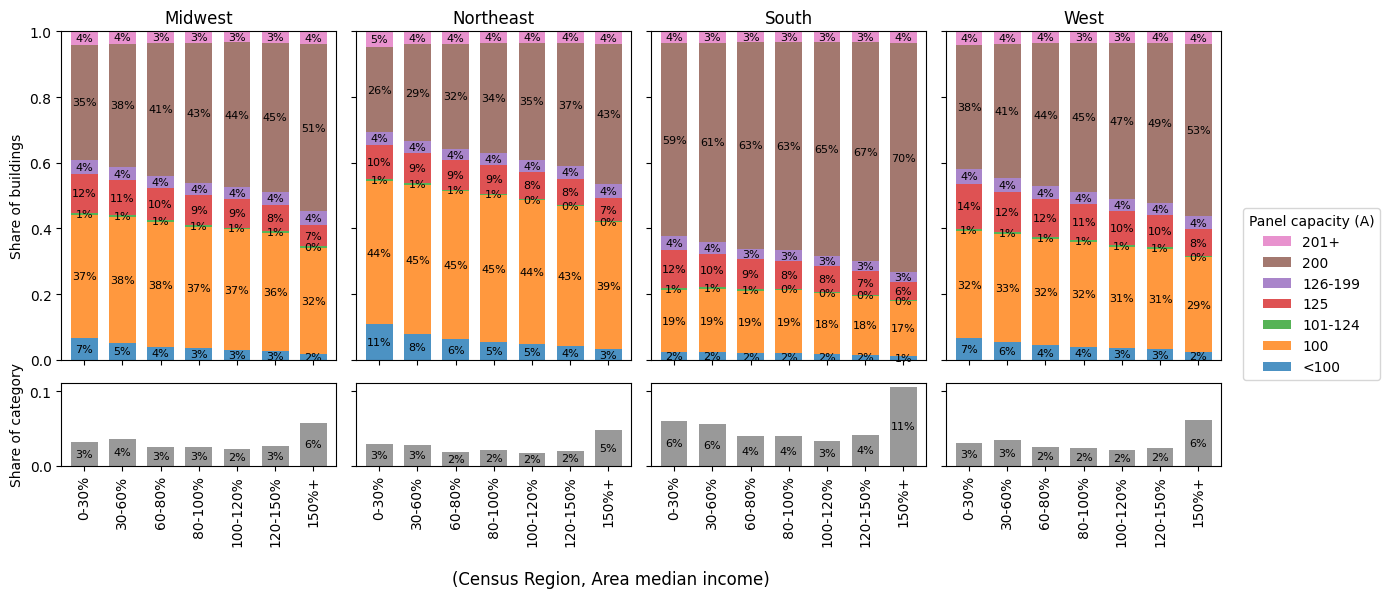

In [37]:
group_bys = [
    "build_existing_model.vintage",
    "build_existing_model.geometry_floor_area",
    "build_existing_model.geometry_building_type_recs",
    "build_existing_model.federal_poverty_level",
    "build_existing_model.area_median_income",
]
labels = [
    "Vintage",
    "Floor area",
    "Building type",
    "Federal poverty level",
    "Area median income",
]

for gbc, xlab in zip(group_bys, labels):
    xlab = f"(Census Region, {xlab})"
    
    dfi = dfm.groupby(["build_existing_model.census_region", gbc])[metric_cols].sum()
    dfc = dfm.groupby(["build_existing_model.census_region", gbc])["building_id"].count()
    
    dfi = dfi.divide(dfi.sum(axis=1), axis=0)
    dfc = sort_index(dfc.divide(dfc.sum()))
    dfi = sort_index(sort_index(dfi, axis=0), axis=1)
    
    fig, axes = plt.subplots(nrows=2, ncols=4, sharex=True, sharey="row", gridspec_kw={'height_ratios': [4,1]}, 
                             figsize=(3.75+1.25*dfm[gbc].nunique(), 6))
    for k, reg in enumerate(sorted(dfi.index.get_level_values(level=0).unique())):
        ax1 = axes[0,k]
        dfii = sort_index(sort_index(dfi.loc[(reg)], axis=0), axis=1)
        dfii.plot(kind="bar", stacked=True,  alpha=0.8, width=0.7, ax=ax1, legend=False)
        # ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5), reverse=True, title="Panel capacity (A)")
        ax1.set_ylim(0,1)
        ax1.set_ylabel(f"Share of buildings")
        ax1.set_title(reg)
        
        for i, row in dfii.reset_index(drop=True).iterrows():
            for j in range(len(row)):
                ax1.text(i, row.iloc[0:j].sum()+row.iloc[j]/2, f"{row.iloc[j]*100:.0f}%", ha="center", va="center", fontsize=8)
                
        ax2 = axes[1,k]
        dfcc = sort_index(dfc.loc[(reg)])
        dfcc.plot(kind="bar", stacked=False, color="gray", alpha=0.8, width=0.7, ax=ax2, legend=False)
        ax2.set_xticks(ticks = range(len(dfcc)), labels = format_labels(dfcc.index))
        ax2.set_xlabel(None)
        ax2.set_ylabel("Share of category")
        
        for j in range(len(dfcc)):
            ax2.text(j, dfcc.iloc[j]/2, f"{dfcc.iloc[j]*100:.0f}%", ha="center", va="center", fontsize=8)

    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(reversed(handles), reversed(labels), title="Panel capacity (A)", loc='center left', bbox_to_anchor=(1, 0.5))
    
    fig.supxlabel(xlab)
    plt.tight_layout()
    
    metric = f"label_proba_by_{xlab}"
    fig.savefig(output_dir / f"2stacked_bar__{metric}.png", dpi=400, bbox_inches="tight")

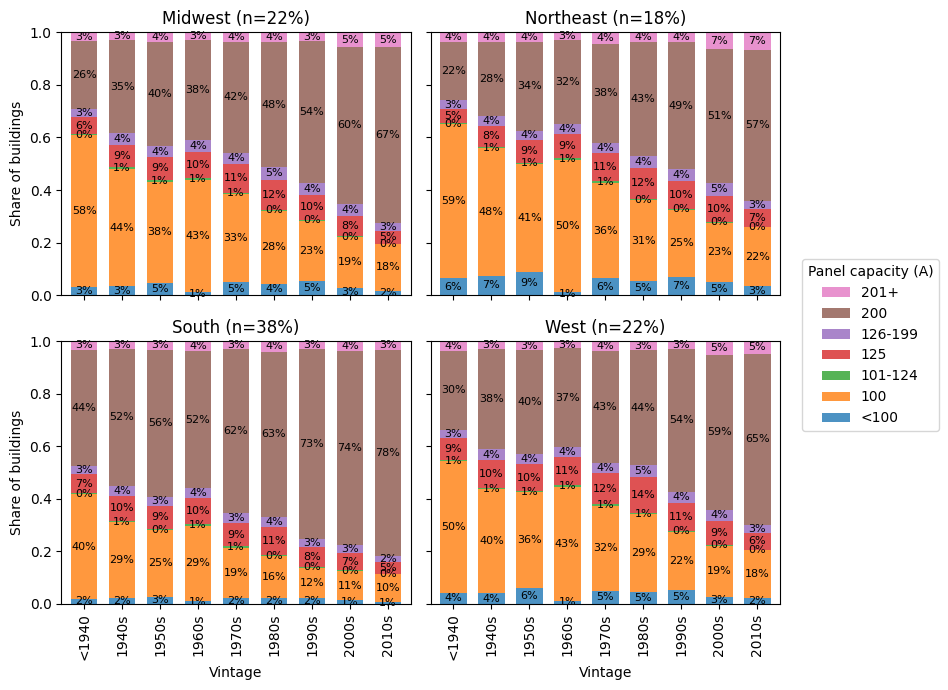

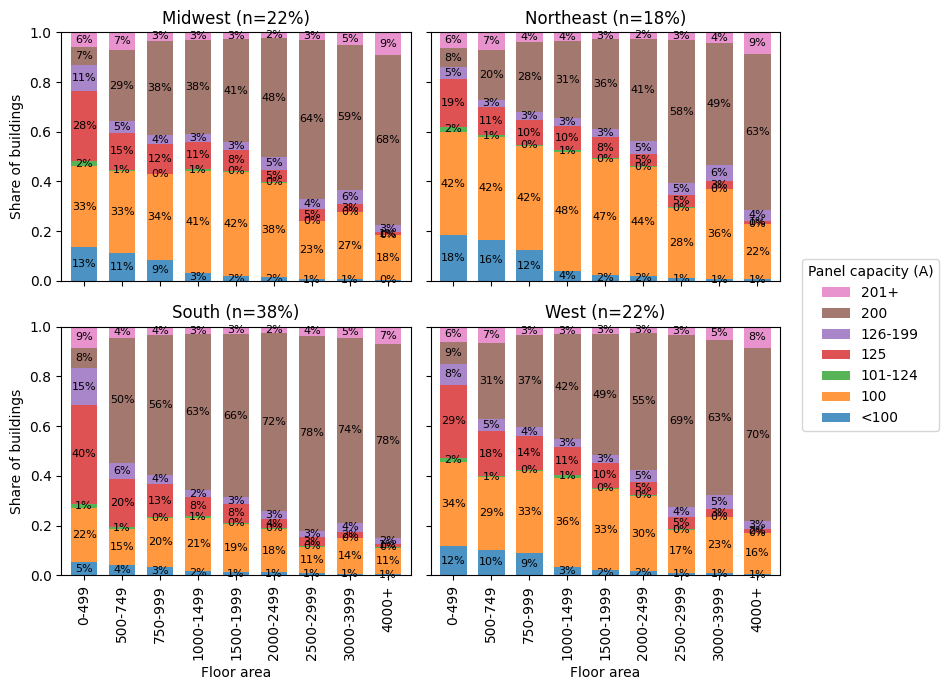

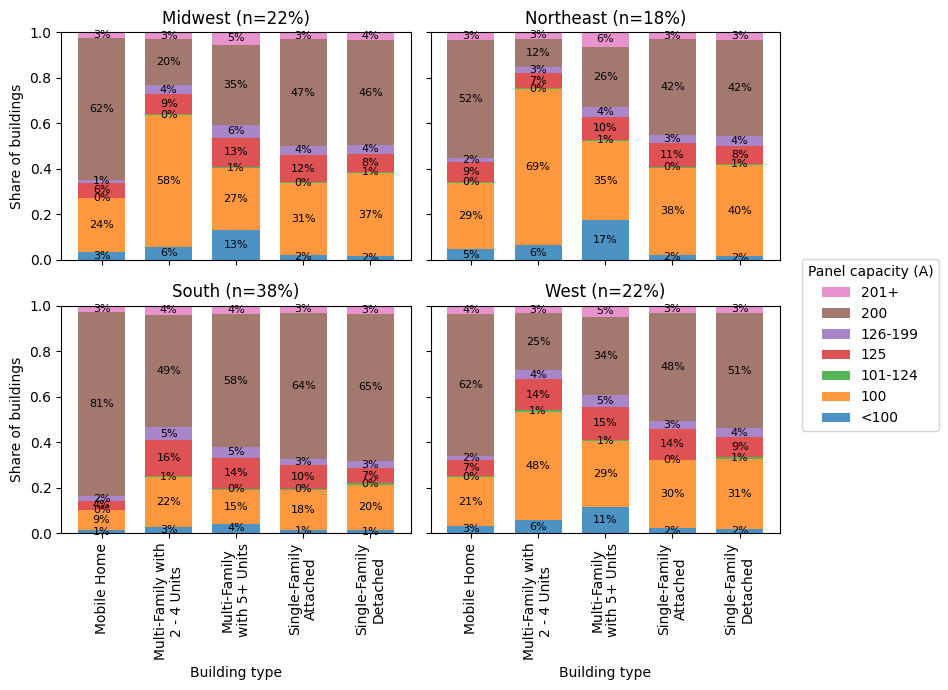

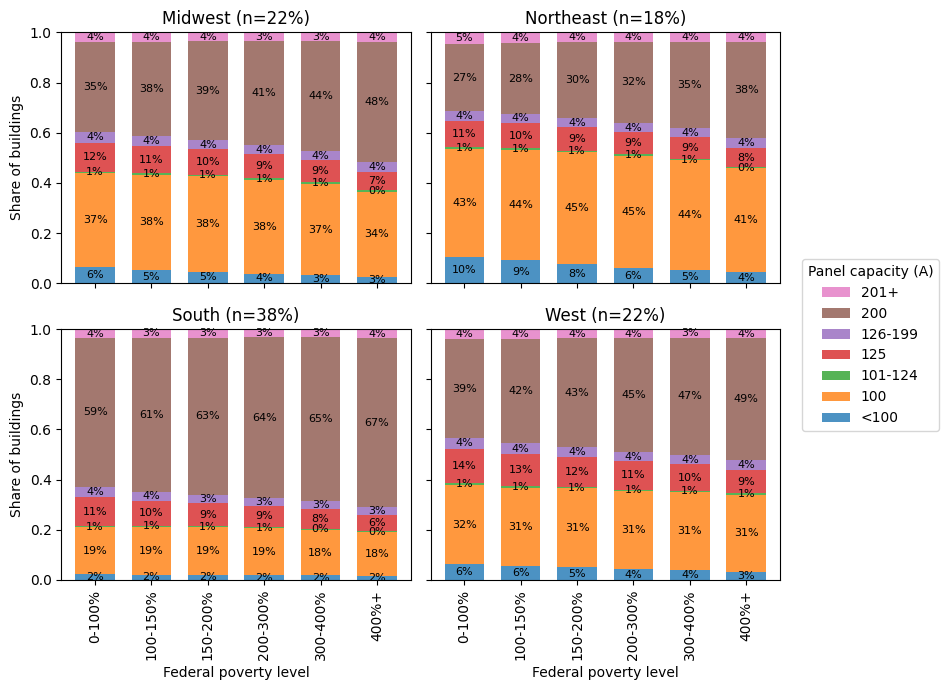

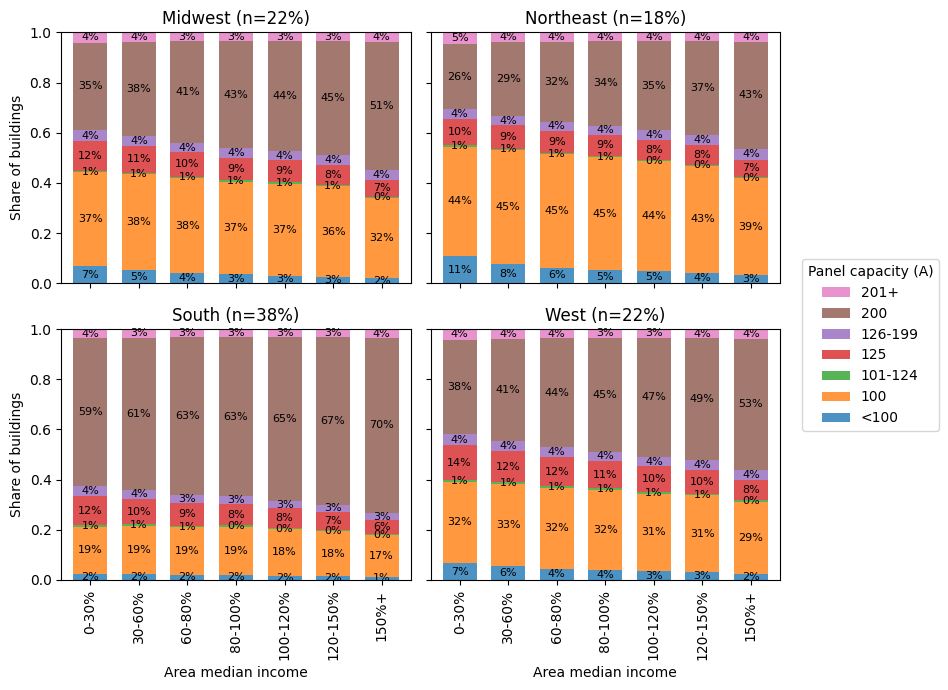

In [38]:
group_bys = [
    "build_existing_model.vintage",
    "build_existing_model.geometry_floor_area",
    "build_existing_model.geometry_building_type_recs",
    "build_existing_model.federal_poverty_level",
    "build_existing_model.area_median_income",
]
labels = [
    "Vintage",
    "Floor area",
    "Building type",
    "Federal poverty level",
    "Area median income",
]

for group_by, xlab in zip(group_bys, labels):
    subplot_by = "build_existing_model.census_region" # fixed - for # of axes and fig output name
    dfi = dfm.groupby([subplot_by, group_by])[metric_cols].sum()
    
    dfi = dfi.divide(dfi.sum(axis=1), axis=0)
    dfi = sort_index(sort_index(dfi, axis=0), axis=1)
    dfi = dfi.unstack(level=0)
    dfi = dfi.swaplevel(i=-2, j=-1, axis=1).sort_index(axis=1)
    
    # get count of subplot_by
    dfc = dfm.groupby(subplot_by)["building_id"].count()
    dfc = dfc/dfc.sum()
    
    fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(8,7))
    
    for k, reg in enumerate(dfi.columns.get_level_values(level=0).unique()):
        dfii = dfi.iloc[:, dfi.columns.get_level_values(level=0)==reg][reg]
        dfii = sort_index(sort_index(dfii, axis=0), axis=1)
    
        ax = axes[k //2,  k % 2]
        dfii.plot(kind="bar", stacked=True,  alpha=0.8, width=0.7, ax=ax, legend=False)
        ax.set_ylim(0,1)
        ax.set_ylabel(f"Share of buildings")
        ax.set_xlabel(xlab)
        ax.set_xticks(ticks = range(len(dfii)), labels = format_labels(dfii.index))
        ax.set_title(f"{reg} (n={dfc[reg]*100:.0f}%)")
        
        for i, row in dfii.reset_index(drop=True).iterrows():
            for j in range(len(row)):
                ax.text(i, row.iloc[0:j].sum()+row.iloc[j]/2, f"{row.iloc[j]*100:.0f}%", ha="center", va="center", fontsize=8)
    
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(reversed(handles), reversed(labels), title="Panel capacity (A)", loc='center left', bbox_to_anchor=(1, 0.5))

    plt.tight_layout()

    metric = f"label_proba_by_{xlab}_subplot_by_census_region"
    fig.savefig(output_dir / f"1stacked_bar__{metric}.png", dpi=400, bbox_inches="tight")
    dfi.to_csv(output_dir / f"data__1stacked_bar__{metric}.csv", index=True)

### [3] plot rep value prediction vs. NEC

In [39]:
def bin_panel_cap_headroom(df_column):
    # 10A single heating element heater
    # 5kVA ~ 20A (dryer)
    # 7.2kVA ~ 30A (EVSE)
    # 12kVA ~ 50A (cooking)

    try:
        df_column = df_column.astype(float)
    except ValueError as e:
        df_column = df_column.replace('', np.nan).astype(float)

    df_out = pd.Series(np.nan, index=df_column.index)
    df_out.loc[df_column<=0] = "0A"
    df_out.loc[(df_column>0) & (df_column<10)] = "1-9A"
    df_out.loc[(df_column>=10) & (df_column<20)] = "10-19A"
    df_out.loc[(df_column>=20) & (df_column<30)] = "20-29A"
    df_out.loc[(df_column>=30) & (df_column<50)] = "30-49A"
    df_out.loc[(df_column>=50)] = "50+A"

    categories = ["0A", "1-9A", "10-19A", "20-29A", "30-49A", "50+A"]
    df_out = pd.Categorical(df_out, ordered=True, categories=categories)

    assert df_out.isna().sum() == 0, f"{df_out.isna().sum()} NA values after binning panel capacity headroom"

    return df_out

In [45]:
### combine prediction with NEC calc
print(f"Using {method} for representative value of panel amperage...")
df = dfn.join(
    dfm.set_index("building_id")[["predicted_panel_amp_bin", "predicted_panel_amp"]],
    on="building_id"
)
df["headroom_amp_220_83"] = df["predicted_panel_amp"] - df["amp_total_pre_upgrade_A_220_83"]
df["headroom_amp_220_87"] = df["predicted_panel_amp"] - df["amp_total_pre_upgrade_A_220_87"]
df["headroom_pct_220_83"] = (df["headroom_amp_220_83"] / df["predicted_panel_amp"])*100
df["headroom_pct_220_87"] = (df["headroom_amp_220_87"] / df["predicted_panel_amp"])*100

df["headroom_amp_bin_220_83"] = bin_panel_cap_headroom(df["headroom_amp_220_83"])
df["headroom_amp_bin_220_87"] = bin_panel_cap_headroom(df["headroom_amp_220_87"])
df

Using lookup for representative value of panel amperage...


,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,build_existing_model.ahs_region,build_existing_model.aiannh_area,...,load_total_pre_upgrade_VA_220_87,amp_total_pre_upgrade_A_220_87,predicted_panel_amp_bin,predicted_panel_amp,headroom_amp_220_83,headroom_amp_220_87,headroom_pct_220_83,headroom_pct_220_87,headroom_amp_bin_220_83,headroom_amp_bin_220_87
0,1,181,2024-08-15 13:45:49,2024-08-15 13:46:10,Success,<NA>,<NA>,,Non-CBSA East South Central,Yes,...,17386.750,72.444792,200,200,109.077717,127.555208,54.538858,63.777604,50+A,50+A
1,2,262,2024-08-16 13:33:53,2024-08-16 13:34:13,Success,<NA>,<NA>,,Non-CBSA New England,No,...,4765.375,19.855729,<100,60,13.131868,40.144271,21.886446,66.907118,10-19A,30-49A
2,3,262,2024-08-16 14:17:45,2024-08-16 14:18:08,Success,<NA>,<NA>,,"CBSA Boston-Cambridge-Newton, MA-NH",No,...,6757.125,28.154688,100,100,44.641367,71.845313,44.641367,71.845313,30-49A,50+A
3,4,102,2024-08-15 06:32:40,2024-08-15 06:32:59,Success,<NA>,<NA>,,Non-CBSA West South Central,No,...,7315.500,30.481250,200,200,137.837897,169.518750,68.918948,84.759375,50+A,50+A
4,5,28,2024-08-14 17:54:32,2024-08-14 17:54:56,Success,<NA>,<NA>,,"CBSA Riverside-San Bernardino-Ontario, CA",No,...,5209.125,21.704687,200,200,161.701608,178.295312,80.850804,89.147656,50+A,50+A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
483058,549995,288,2024-08-15 18:34:05,2024-08-15 18:34:36,Success,<NA>,<NA>,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",No,...,9687.750,40.365625,200,200,152.091868,159.634375,76.045934,79.817188,50+A,50+A
483059,549996,201,2024-08-16 08:01:45,2024-08-16 08:02:16,Success,<NA>,<NA>,,Non-CBSA South Atlantic,No,...,17549.500,73.122917,200,200,97.118230,126.877083,48.559115,63.438542,50+A,50+A
483060,549997,267,2024-08-16 14:10:45,2024-08-16 14:11:13,Success,<NA>,<NA>,,Non-CBSA Middle Atlantic,No,...,13581.500,56.589583,100,100,28.709577,43.410417,28.709577,43.410417,20-29A,30-49A
483061,549998,129,2024-08-15 08:33:08,2024-08-15 08:33:35,Success,<NA>,<NA>,,"CBSA Los Angeles-Long Beach-Anaheim, CA",No,...,6418.875,26.745313,100,100,29.771446,73.254688,29.771446,73.254688,20-29A,50+A


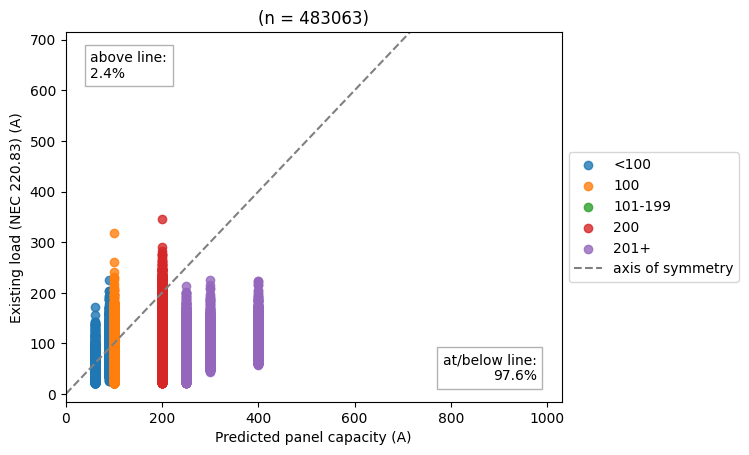

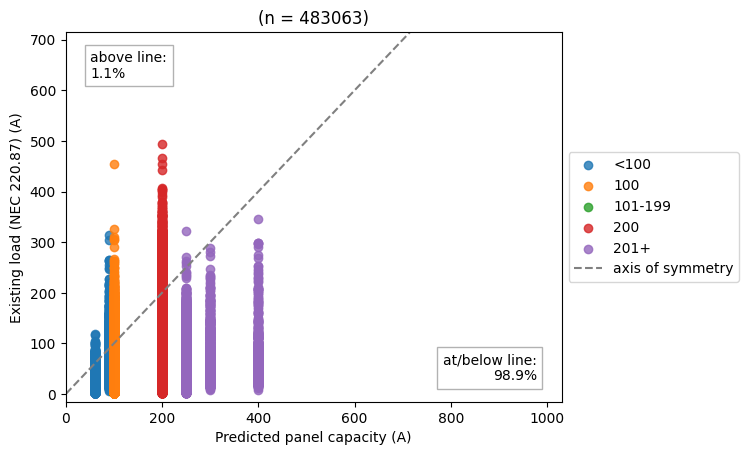

In [46]:
# scatter plots
y_metrics = [
    "amp_total_pre_upgrade_A_220_83",
    "amp_total_pre_upgrade_A_220_87",
]

y_labels = [
    "Existing load (NEC 220.83) (A)",
    "Existing load (NEC 220.87) (A)",
]

for y_metric, y_label in zip(y_metrics, y_labels):
    x_metric = "predicted_panel_amp"
    x_label = "Predicted panel capacity (A)"
    
    title = None
    dfp = df[[x_metric, y_metric, "predicted_panel_amp_bin"]].dropna(how="any")
    assert dfp[x_metric].dtype == int, f"{x_metric=} is of type {dfp[x_metric].dtype=}"
    assert dfp[y_metric].dtype == float, f"{y_metric=} is of type {dfp[y_metric].dtype=}"
    
    fig, ax = plt.subplots()
    for bin, color in zip(
        ["<100", "100", "101-199", "200", "201+"],
        ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple'],
    ):
        x = dfp.loc[dfp["predicted_panel_amp_bin"]==bin, x_metric]
        y = dfp.loc[dfp["predicted_panel_amp_bin"]==bin, y_metric]
        ax.scatter(x, y, label=bin, c=color, alpha=0.8)
        
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_xlim(0, 1030)
    ax.set_ylim(-15, 715)
    ax.margins(x=0, y=0)
    
    lxy = np.array([
        min(ax.get_xlim()[0], ax.get_ylim()[0]), 
        max(ax.get_xlim()[1], ax.get_ylim()[1]), 
        ])
    ax.plot(lxy, lxy, label="axis of symmetry", ls="--", c="gray")
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    # calculate % above and at or below x=y
    frac = dfp[y_metric]/dfp[x_metric]
    frac_above = len(frac[frac>1]) / len(frac)
    frac_at_below = 1-frac_above
    ax.text(0.05, 0.95, f"above line:\n{frac_above*100:.1f}%", ha="left", va="top", transform=ax.transAxes, 
            bbox=dict(facecolor='w', alpha=0.3))
    ax.text(0.95, 0.05, f"at/below line:\n{frac_at_below*100:.1f}%", ha="right", va="bottom", transform=ax.transAxes, 
            bbox=dict(facecolor='w', alpha=0.3))
    
    title_ext = f"(n = {len(dfp)})"
    if title is not None:
        title += f" {title_ext}"
    else:
        title = title_ext
    ax.set_title(title)
    if output_dir is not None:
        fig.savefig(output_dir / f"scatter__{y_metric}_by_{x_metric}_{method}.png", dpi=400, bbox_inches="tight")

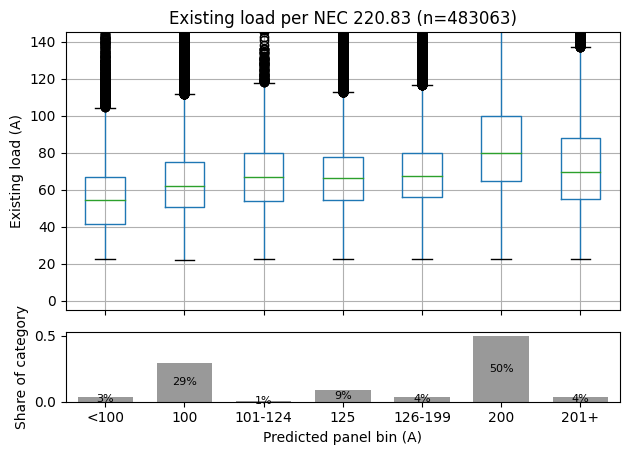

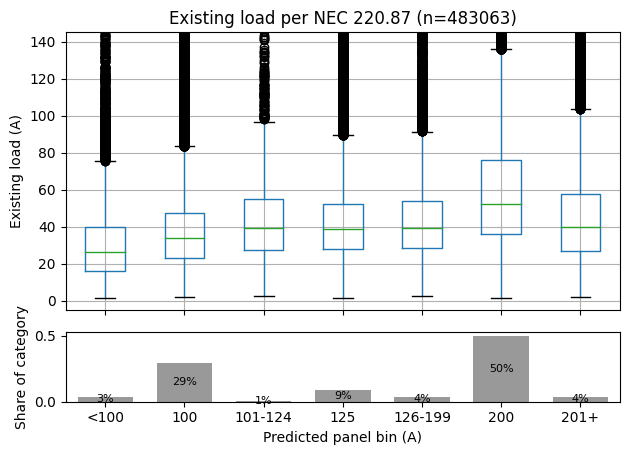

In [47]:
# box plots -- existing load
for panel_metric in [
    "amp_total_pre_upgrade_A_220_83", 
    "amp_total_pre_upgrade_A_220_87"
]:
    
    by_var = "predicted_panel_amp_bin"
    
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, gridspec_kw={'height_ratios': [4,1]})
    df[[by_var, panel_metric]].boxplot(by=by_var, ax=ax1, showfliers=True)
    ax1.set_ylabel("Existing load (A)")
    ax1.set_ylim(-5,145) # adjust ylim by looking at natural ylim with showfliers=False in .boxplot()
    if "83" in panel_metric:
        ax1.set_title(f"Existing load per NEC 220.83 (n={len(df)})")
    else:
        ax1.set_title(f"Existing load per NEC 220.87 (n={len(df)})")
    
    dfc = sort_index(df[by_var].value_counts()) / len(df)
    pd.concat([
        pd.Series(0, index=[""]),
        dfc], axis=0).plot(kind="bar", stacked=False, color="gray", alpha=0.8, width=0.7, ax=ax2)
    ax2.set_xlim(0.5,len(dfc)+0.5)
    ax2.set_xticks(ticks = range(1, len(dfc)+1), labels = format_labels(dfc.index), rotation=0)
    
    ax2.set_xlabel("Predicted panel bin (A)")
    ax2.set_ylabel("Share of category")
    
    for j in range(len(dfc)):
        ax2.text(j+1, dfc.iloc[j]/2, f"{dfc.iloc[j]*100:.0f}%", ha="center", va="center", fontsize=8)
    
    fig_file = f"box__{panel_metric}_by_{by_var}.png"
    if output_dir is not None:
        fig_file = output_dir / fig_file
    
    plt.suptitle(None)
    plt.tight_layout()
    fig.savefig(fig_file, dpi=400, bbox_inches="tight")

In [100]:
panel_labels = metric_cols
existing_load_methods = ["amp_total_pre_upgrade_A_220_83", "amp_total_pre_upgrade_A_220_87"]

for mtd in existing_load_methods:
    print(f"\nUsing {mtd} to calculate existing load:")
    
    for label in panel_labels:        
        cond = df["predicted_panel_amp_bin"].isin([label]) 
        
        loads = df.loc[cond, mtd]
        upper = np.percentile(loads, 75) + 1.5*(np.percentile(loads, 75) - np.percentile(loads, 25))
        lower = np.percentile(loads, 25) - 1.5*(np.percentile(loads, 75) - np.percentile(loads, 25))
        cond_outliers = cond & ((df[mtd]<lower) | (df[mtd]>upper))
        n_outliers = len(df.loc[cond_outliers])
        pct_outliers = n_outliers / len(loads) * 100
        
        print(f"For label: {label}...")
        print(f" - outliers: {n_outliers} ( {pct_outliers:.02f} % ) ")
        
        cond_err = cond & (df["predicted_panel_amp"]<df[mtd])
        n_err = len(df.loc[cond_err])
        pct_err = n_err / len(loads) * 100
        print(f" - homes where existing load > panel amp: {n_err} ( {pct_err:.02f} % ) ")
        print(f" - homes where existing load =< panel amp (with no or some headroom): {len(loads) - n_err} ( {(100-pct_err):.02f} % ) ")


Using amp_total_pre_upgrade_A_220_83 to calculate existing load:
For label: <100...
 - outliers: 480 ( 2.86 % ) 
 - homes where existing load > panel amp: 5248 ( 31.22 % ) 
 - homes where existing load =< panel amp (with no or some headroom): 11564 ( 68.78 % ) 
For label: 100...
 - outliers: 2402 ( 1.69 % ) 
 - homes where existing load > panel amp: 5069 ( 3.57 % ) 
 - homes where existing load =< panel amp (with no or some headroom): 136864 ( 96.43 % ) 
For label: 101-124...
 - outliers: 95 ( 3.78 % ) 
 - homes where existing load > panel amp: 79 ( 3.14 % ) 
 - homes where existing load =< panel amp (with no or some headroom): 2437 ( 96.86 % ) 
For label: 125...
 - outliers: 1403 ( 3.22 % ) 
 - homes where existing load > panel amp: 701 ( 1.61 % ) 
 - homes where existing load =< panel amp (with no or some headroom): 42915 ( 98.39 % ) 
For label: 126-199...
 - outliers: 635 ( 3.51 % ) 
 - homes where existing load > panel amp: 111 ( 0.61 % ) 
 - homes where existing load =< panel amp

In [ ]:
print("Total error from 83 (Load Summing), Error if existing load is > predicted panel size:")
# error:= "predicted_panel_amp_bin" > "amp_total_pre_upgrade_A_220_83"
cond = df["predicted_panel_amp"]<df["amp_total_pre_upgrade_A_220_83"]
df_error = df.loc[cond]

print(f"# of samples: {len(df_error)}")
print(f"% of samples: {len(df_error) / len(df)}")

###
print("\nTotal error from 87 (Max Demand), Error if existing load is > predicted panel size:")
# error:= "predicted_panel_amp_bin" > "amp_total_pre_upgrade_A_220_87"
cond = df["predicted_panel_amp"]<df["amp_total_pre_upgrade_A_220_87"]
df_error = df.loc[cond]

print(f"# of samples: {len(df_error)}")
print(f"% of samples: {len(df_error) / len(df)}")

In [49]:
# How much is existing load by NEC 220.87 lower than 220.83:
((df["amp_total_pre_upgrade_A_220_87"]-df["amp_total_pre_upgrade_A_220_83"])/df["amp_total_pre_upgrade_A_220_83"]).describe()

count    483063.000000
mean         -0.359584
std           0.250260
min          -0.940212
25%          -0.528283
50%          -0.401167
75%          -0.224206
max           4.182709
dtype: float64

In [50]:
# How much is more headroom is calculated by NEC 220.87 than 220.83:
(df["headroom_amp_220_87"]-df["headroom_amp_220_83"]).describe()

count    483063.000000
mean         24.242742
std          19.923951
min        -321.023308
25%          15.913322
50%          25.785195
75%          35.256826
max         156.264866
dtype: float64

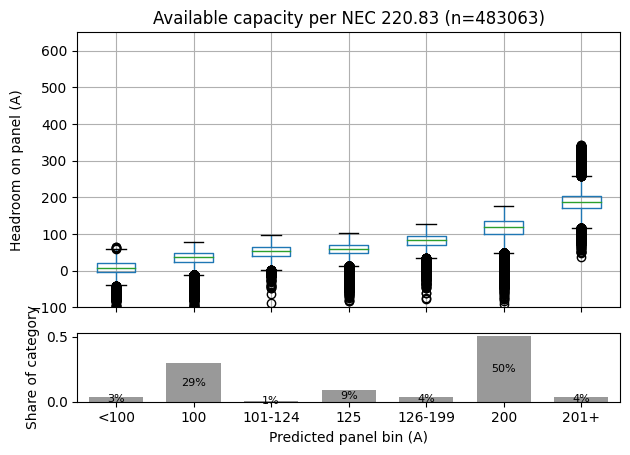

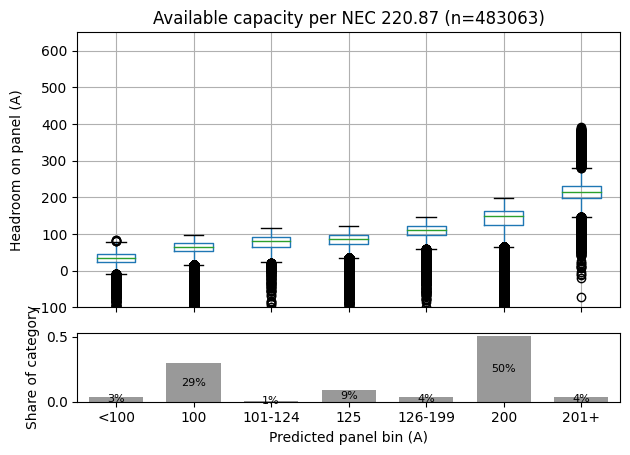

In [52]:
# box plots -- Head room abs
for panel_metric in [
    "headroom_amp_220_83", 
    "headroom_amp_220_87"
]:
    
    by_var = "predicted_panel_amp_bin"
    
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, gridspec_kw={'height_ratios': [4,1]})
    df[[by_var, panel_metric]].boxplot(by=by_var, ax=ax1, showfliers=True)
    ax1.set_ylabel("Headroom on panel (A)")
    ax1.set_ylim(-100, 650) # adjust ylim by looking at natural ylim with showfliers=False in .boxplot()
    if "83" in panel_metric:
        ax1.set_title(f"Available capacity per NEC 220.83 (n={len(df)})")
    else:
        ax1.set_title(f"Available capacity per NEC 220.87 (n={len(df)})")
    
    dfc = sort_index(df[by_var].value_counts()) / len(df)
    pd.concat([
        pd.Series(0, index=[""]),
        dfc], axis=0).plot(kind="bar", stacked=False, color="gray", alpha=0.8, width=0.7, ax=ax2)
    ax2.set_xlim(0.5,len(dfc)+0.5)
    ax2.set_xticks(ticks = range(1, len(dfc)+1), labels = format_labels(dfc.index), rotation=0)
    
    ax2.set_xlabel("Predicted panel bin (A)")
    ax2.set_ylabel("Share of category")
    
    for j in range(len(dfc)):
        ax2.text(j+1, dfc.iloc[j]/2, f"{dfc.iloc[j]*100:.0f}%", ha="center", va="center", fontsize=8)
    
    fig_file = f"box__{panel_metric}_by_{by_var}.png"
    if output_dir is not None:
        fig_file = output_dir / fig_file
    
    plt.suptitle(None)
    plt.tight_layout()
    fig.savefig(fig_file, dpi=400, bbox_inches="tight")

In [94]:
# tabulate fractions of homes by binned cap headroom
existing_load_methods = ["headroom_amp_bin_220_83", "headroom_amp_bin_220_87"]
for mtd in existing_load_methods:
    groupby_cols = ["predicted_panel_amp_bin", mtd]
    dfi = df.groupby(groupby_cols)["building_id"].count().unstack().div(df.groupby(["predicted_panel_amp_bin"])["building_id"].count(), axis=0)
    display((dfi*100).round(1))
    dfi.to_csv(output_dir / f"data__fraction_homes__{mtd}.csv", index=True)

headroom_amp_bin_220_83,0A,1-9A,10-19A,20-29A,30-49A,50+A
predicted_panel_amp_bin,,,,,,
<100,31.2,26.7,15.4,20.9,5.6,0.2
100,3.6,3.7,9.7,17.5,41.5,24.0
101-124,3.1,2.8,3.2,5.6,30.2,55.0
125,1.6,1.2,2.2,3.6,21.8,69.6
126-199,0.6,0.4,0.8,1.2,5.0,92.0
200,0.1,0.1,0.2,0.3,1.5,97.7
201+,0.0,0.0,0.0,0.0,0.0,100.0


headroom_amp_bin_220_87,0A,1-9A,10-19A,20-29A,30-49A,50+A
predicted_panel_amp_bin,,,,,,
<100,4.8,5.1,9.6,16.5,49.2,14.8
100,1.3,0.7,1.2,2.5,15.6,78.7
101-124,2.6,1.1,1.1,1.9,7.4,85.9
125,1.3,0.6,0.7,1.0,4.3,92.0
126-199,0.9,0.3,0.4,0.5,1.7,96.1
200,0.8,0.3,0.3,0.4,1.4,96.8
201+,0.0,0.0,0.0,0.0,0.1,99.9


In [54]:
panel_labels = metric_cols
existing_load_methods = ["headroom_amp_220_83", "headroom_amp_220_87"]

for mtd in existing_load_methods:
    print(f"\nUsing {mtd} to calculate existing load:")

    table = []
    for label in panel_labels:        
        cond = df["predicted_panel_amp_bin"].isin([label]) 
        
        loads = df.loc[cond, mtd]
        upper = np.percentile(loads, 75) + 1.5*(np.percentile(loads, 75) - np.percentile(loads, 25))
        lower = np.percentile(loads, 25) - 1.5*(np.percentile(loads, 75) - np.percentile(loads, 25))
        cond_outliers = cond & ((df[mtd]<lower) | (df[mtd]>upper))
        n_outliers = len(df.loc[cond_outliers])
        pct_outliers = n_outliers / len(loads) * 100
        
        print(f"For label: {label}...")
        print(f" - outliers: {n_outliers} ( {pct_outliers:.02f} % ) ")
    


Using headroom_amp_220_83 to calculate existing load:
For label: <100...
 - outliers: 179 ( 1.06 % ) 
For label: 100...
 - outliers: 2402 ( 1.69 % ) 
For label: 101-124...
 - outliers: 95 ( 3.78 % ) 
For label: 125...
 - outliers: 1403 ( 3.22 % ) 
For label: 126-199...
 - outliers: 635 ( 3.51 % ) 
For label: 200...
 - outliers: 4807 ( 1.98 % ) 
For label: 201+...
 - outliers: 1454 ( 8.29 % ) 

Using headroom_amp_220_87 to calculate existing load:
For label: <100...
 - outliers: 464 ( 2.76 % ) 
For label: 100...
 - outliers: 3763 ( 2.65 % ) 
For label: 101-124...
 - outliers: 131 ( 5.21 % ) 
For label: 125...
 - outliers: 1935 ( 4.44 % ) 
For label: 126-199...
 - outliers: 887 ( 4.91 % ) 
For label: 200...
 - outliers: 11560 ( 4.77 % ) 
For label: 201+...
 - outliers: 1949 ( 11.11 % ) 


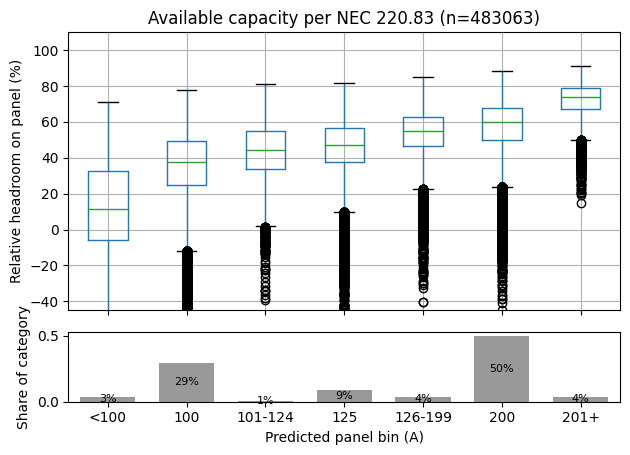

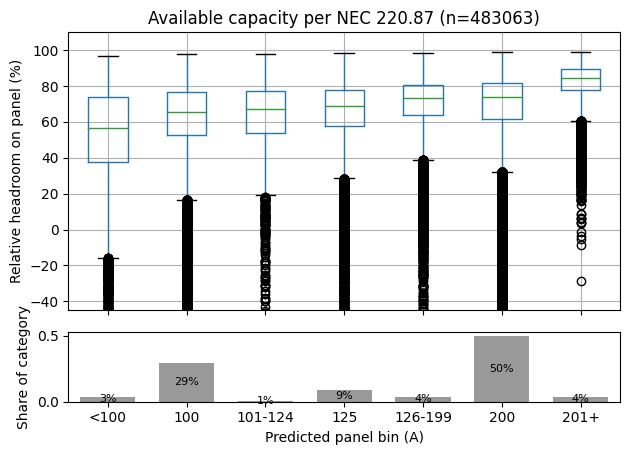

In [55]:
# box plots -- Head room %
for panel_metric in [
    "headroom_pct_220_83", 
    "headroom_pct_220_87"
]:
    
    by_var = "predicted_panel_amp_bin"
    
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, gridspec_kw={'height_ratios': [4,1]})
    df[[by_var, panel_metric]].boxplot(by=by_var, ax=ax1, showfliers=True)
    ax1.set_ylabel("Relative headroom on panel (%)")
    ax1.set_ylim(-45, 110) # adjust ylim by looking at natural ylim with showfliers=False in .boxplot()
    if "83" in panel_metric:
        ax1.set_title(f"Available capacity per NEC 220.83 (n={len(df)})")
    else:
        ax1.set_title(f"Available capacity per NEC 220.87 (n={len(df)})")
    
    dfc = sort_index(df[by_var].value_counts()) / len(df)
    pd.concat([
        pd.Series(0, index=[""]),
        dfc], axis=0).plot(kind="bar", stacked=False, color="gray", alpha=0.8, width=0.7, ax=ax2)
    ax2.set_xlim(0.5,len(dfc)+0.5)
    ax2.set_xticks(ticks = range(1, len(dfc)+1), labels = format_labels(dfc.index), rotation=0)
    
    ax2.set_xlabel("Predicted panel bin (A)")
    ax2.set_ylabel("Share of category")
    
    for j in range(len(dfc)):
        ax2.text(j+1, dfc.iloc[j]/2, f"{dfc.iloc[j]*100:.0f}%", ha="center", va="center", fontsize=8)
    
    fig_file = f"box__{panel_metric}_by_{by_var}.png"
    if output_dir is not None:
        fig_file = output_dir / fig_file
    
    plt.suptitle(None)
    plt.tight_layout()
    fig.savefig(fig_file, dpi=400, bbox_inches="tight")

### [4.1] State maps

In [72]:
panel_label1 = "% dwelling units"
title = "Electrical panels 100 Amp or less"
dfcond = df.loc[df["predicted_panel_amp_bin"].isin(["<100", "100"])]
data1 = (dfcond.groupby(["build_existing_model.state"])["build_existing_model.sample_weight"].sum() / \
        df.groupby(["build_existing_model.state"])["build_existing_model.sample_weight"].sum()*100).rename(panel_label1)
data1.index.name = "State"
data1 = data1.reset_index()

# plot
fig = px.choropleth(data1, locations='State', color=panel_label1, title=title,
                    locationmode="USA-states", color_continuous_scale=px.colors.sequential.RdBu_r, scope="usa")
fig.add_scattergeo(locations=data1['State'], text=data1[panel_label1].astype(float).round(0), 
                   locationmode="USA-states", mode='markers+text', opacity=1,
                   textfont=dict(color="black", size=10),
                   marker=dict(color="white", size=15, opacity=0.6),
                  )
fig.show()
fig_file = f"map__{panel_label1}_{title}.png"
if output_dir is not None:
    fig_file = output_dir / fig_file
pio.write_image(fig, fig_file, scale=6, width=1000, height=500)

In [73]:
panel_label2 = "% dwelling units"
title = "Electrical panels 200 Amp or more"
dfcond = df.loc[df["predicted_panel_amp_bin"].isin(["200", "201+"])]
data2 = (dfcond.groupby(["build_existing_model.state"])["build_existing_model.sample_weight"].sum() / \
        df.groupby(["build_existing_model.state"])["build_existing_model.sample_weight"].sum()*100).rename(panel_label2)
data2.index.name = "State"
data2 = data2.reset_index()

# plot
fig = px.choropleth(data2, locations='State', color=panel_label2, title=title,
                    locationmode="USA-states", color_continuous_scale=px.colors.sequential.RdBu_r, scope="usa")
fig.add_scattergeo(locations=data2['State'], text=data2[panel_label2].astype(float).round(0), 
                   locationmode="USA-states", mode='markers+text', opacity=1,
                   textfont=dict(color="black", size=10),
                   marker=dict(color="white", size=15, opacity=0.6),
                  )

fig.show()
fig_file = f"map__{panel_label2}_{title}.png"
if output_dir is not None:
    fig_file = output_dir / fig_file
pio.write_image(fig, fig_file, scale=6, width=800, height=500)

In [74]:
panel_label2 = "% dwelling units"
title = "Electrical panels less than 200 Amp"
dfcond = df.loc[~df["predicted_panel_amp_bin"].isin(["200", "201+"])]
data2 = (dfcond.groupby(["build_existing_model.state"])["build_existing_model.sample_weight"].sum() / \
        df.groupby(["build_existing_model.state"])["build_existing_model.sample_weight"].sum()*100).rename(panel_label2)
data2.index.name = "State"
data2 = data2.reset_index()

# plot
fig = px.choropleth(data2, locations='State', color=panel_label2, title=title,
                    locationmode="USA-states", color_continuous_scale=px.colors.sequential.RdBu_r, scope="usa")
fig.add_scattergeo(locations=data2['State'], text=data2[panel_label2].astype(float).round(0), 
                   locationmode="USA-states", mode='markers+text', opacity=1,
                   textfont=dict(color="black", size=10),
                   marker=dict(color="white", size=15, opacity=0.6),
                  )

fig.show()
fig_file = f"map__{panel_label2}_{title}.png"
if output_dir is not None:
    fig_file = output_dir / fig_file
pio.write_image(fig, fig_file, scale=6, width=800, height=500)

In [75]:
panel_label1 = "% dwelling units"
title = "30 Amp or more available capacity (NEC 220.83)"
dfcond = df.loc[df["headroom_amp_bin_220_83"].isin(["30-49A", "50+A"])]
data1 = (dfcond.groupby(["build_existing_model.state"])["build_existing_model.sample_weight"].sum() / \
        df.groupby(["build_existing_model.state"])["build_existing_model.sample_weight"].sum()*100).rename(panel_label1)
data1.index.name = "State"
data1 = data1.reset_index()

# plot
fig = px.choropleth(data1, locations='State', color=panel_label1, title=title,
                    locationmode="USA-states", color_continuous_scale=px.colors.sequential.RdBu_r, scope="usa")
fig.add_scattergeo(locations=data1['State'], text=data1[panel_label1].astype(float).round(0), 
                   locationmode="USA-states", mode='markers+text', opacity=1,
                   textfont=dict(color="black", size=10),
                   marker=dict(color="white", size=15, opacity=0.6),
                  )

fig.show()
fig_file = f"map__{panel_label1}_{title}.png"
if output_dir is not None:
    fig_file = output_dir / fig_file
pio.write_image(fig, fig_file, scale=6, width=800, height=500)

In [76]:
panel_label2 = "% dwelling units"
title = "30 Amp or more available capacity (NEC 220.87)"
dfcond = df.loc[df["headroom_amp_bin_220_87"].isin(["30-49A", "50+A"])]
data2 = (dfcond.groupby(["build_existing_model.state"])["build_existing_model.sample_weight"].sum() / \
        df.groupby(["build_existing_model.state"])["build_existing_model.sample_weight"].sum()*100).rename(panel_label2)
data2.index.name = "State"
data2 = data2.reset_index()

# plot
fig = px.choropleth(data2, locations='State', color=panel_label2, title=title,
                    locationmode="USA-states", color_continuous_scale=px.colors.sequential.RdBu_r, scope="usa")
fig.add_scattergeo(locations=data2['State'], text=data2[panel_label2].astype(float).round(0), 
                   locationmode="USA-states", mode='markers+text', opacity=1,
                   textfont=dict(color="black", size=10),
                   marker=dict(color="white", size=15, opacity=0.6),
                  )

fig.show()
fig_file = f"map__{panel_label2}_{title}.png"
if output_dir is not None:
    fig_file = output_dir / fig_file
pio.write_image(fig, fig_file, scale=6, width=800, height=500)

### [4.2] County maps

In [77]:
# create county fips for plotting
df["county_fips"] = df["build_existing_model.county_and_puma"].apply(lambda x: x.split(",")[0])
df["county_fips"] = df["county_fips"].apply(lambda x: x[1:3]+x[4:7])


In [88]:
# county level plot
panel_label1 = "% dwelling units"
title = "Electrical panels 100 Amp or less"
dfcond = df.loc[df["predicted_panel_amp_bin"].isin(["<100", "100"])]
data1 = (dfcond.groupby(["county_fips"])["build_existing_model.sample_weight"].sum() / \
        df.groupby(["county_fips"])["build_existing_model.sample_weight"].sum()*100).rename(panel_label1)
data1.index.name = "County"
data1 = data1.reset_index()
data1[panel_label1] = data1[panel_label1].astype(dtype='Float64')

fig = px.choropleth(data1, geojson=counties, locations='County', color=panel_label1, title=title,
                           color_continuous_scale=px.colors.sequential.RdBu_r, scope="usa",)

fig.update_geos(fitbounds="locations", visible=False)
# fig.update_layout(margin={"r":0,"l":0,"b":0})
fig.show()
fig_file = f"map__county_{panel_label1}_{title}.png"
if output_dir is not None:
    fig_file = output_dir / fig_file

pio.write_image(fig, fig_file, scale=6, width=800, height=500)

ValueError: Transform failed with error code 525: Cannot read property '0' of null

In [91]:
panel_label2 = "% dwelling units"
title = "Electrical panels 200 Amp or more"
dfcond = df.loc[df["predicted_panel_amp_bin"].isin(["200", "201+"])]
data2 = (dfcond.groupby(["county_fips"])["build_existing_model.sample_weight"].sum() / \
        df.groupby(["county_fips"])["build_existing_model.sample_weight"].sum()*100).rename(panel_label2)
data2.index.name = "County"
data2 = data2.reset_index()
data2[panel_label2] = data2[panel_label2].astype(dtype='Float64')

fig = px.choropleth(data2, geojson=counties, locations='County', color=panel_label2, title=title,
                           color_continuous_scale=px.colors.sequential.RdBu_r, scope="usa",)

fig.update_geos(fitbounds="locations", visible=False)
# fig.update_layout(margin={"r":0,"t":0, "l":0,"b":0}, height=500, width=800)
fig.show()
fig_file = f"map__county_{panel_label2}_{title}.png"
if output_dir is not None:
    fig_file = output_dir / fig_file

pio.write_image(fig, fig_file, scale=6, width=800, height=500)

ValueError: Transform failed with error code 525: Cannot read property '0' of null

In [92]:
panel_label2 = "% dwelling units"
title = "Electrical panels less than 200 Amp"
dfcond = df.loc[~df["predicted_panel_amp_bin"].isin(["200", "201+"])]
data2 = (dfcond.groupby(["county_fips"])["build_existing_model.sample_weight"].sum() / \
        df.groupby(["county_fips"])["build_existing_model.sample_weight"].sum()*100).rename(panel_label2)
data2.index.name = "County"
data2 = data2.reset_index()
data2[panel_label2] = data2[panel_label2].astype(dtype='Float64')

fig = px.choropleth(data2, geojson=counties, locations='County', color=panel_label2, title=title,
                           color_continuous_scale=px.colors.sequential.RdBu_r, scope="usa",)

fig.update_geos(fitbounds="locations", visible=False)
# fig.update_layout(margin={"r":0,"t":0, "l":0,"b":0}, height=500, width=800)
fig.show()
fig_file = f"map__county_{panel_label2}_{title}.png"
if output_dir is not None:
    fig_file = output_dir / fig_file

pio.write_image(fig, fig_file, scale=6, width=800, height=500)

ValueError: Transform failed with error code 525: Cannot read property '0' of null

In [93]:
panel_label1 = "% dwelling units"
title = "30 Amp or more available capacity (NEC 220.83)"
dfcond = df.loc[df["headroom_amp_bin_220_83"].isin(["30-49A", "50+A"])]
data1 = (dfcond.groupby(["county_fips"])["build_existing_model.sample_weight"].sum() / \
        df.groupby(["county_fips"])["build_existing_model.sample_weight"].sum()*100).rename(panel_label1)
data1.index.name = "County"
data1 = data1.reset_index()
data1[panel_label1] = data1[panel_label1].astype(dtype='Float64')

fig = px.choropleth(data1, geojson=counties, locations='County', color=panel_label1, title=title,
                           color_continuous_scale=px.colors.sequential.RdBu_r, scope="usa",)

fig.update_geos(fitbounds="locations", visible=False)
# fig.update_layout(margin={"r":0,"l":0,"b":0})
fig.show()
fig_file = f"map__county_{panel_label1}_{title}.png"
if output_dir is not None:
    fig_file = output_dir / fig_file

pio.write_image(fig, fig_file, scale=6, width=800, height=500)

ValueError: Transform failed with error code 525: Cannot read property '0' of null

In [ ]:
panel_label2 = "% dwelling units"
title = "30 Amp or more available capacity (NEC 220.87)"
dfcond = df.loc[df["headroom_amp_bin_220_87"].isin(["30-49A", "50+A"])]
data2 = (dfcond.groupby(["county_fips"])["build_existing_model.sample_weight"].sum() / \
        df.groupby(["county_fips"])["build_existing_model.sample_weight"].sum()*100).rename(panel_label2)
data2.index.name = "County"
data2 = data2.reset_index()
data2[panel_label2] = data2[panel_label2].astype(dtype='Float64')

fig = px.choropleth(data2, geojson=counties, locations='County', color=panel_label2, title=title,
                           color_continuous_scale=px.colors.sequential.RdBu_r, scope="usa",)

fig.update_geos(fitbounds="locations", visible=False)
# fig.update_layout(margin={"r":0,"t":0, "l":0,"b":0}, height=500, width=800)
fig.show()
fig_file = f"map__county_{panel_label2}_{title}.png"
if output_dir is not None:
    fig_file = output_dir / fig_file

pio.write_image(fig, fig_file, scale=6, width=800, height=500)

### Miscellaneous Script

In [91]:
### investigate outliers in full survey dataset
data = pd.read_excel("/Uses/lliu2/Documents/GitHub/resstock2/Electrical_Panels_EUSS/model_20240122/outlier_summary.xlsx", 
                   sheet_name="floor area", header=1)
data

FileNotFoundError: [Errno 2] No such file or directory: '/Uses/lliu2/Documents/GitHub/resstock2/Electrical_Panels_EUSS/model_20240122/outlier_summary.xlsx'

In [ ]:
fab = data["geometry_floor_area_bin"].unique()

res = []
for bin in fab:
    dat = data.loc[data["geometry_floor_area_bin"]==bin,["panel_amp_pre", "total count"]]
    panel_list = np.repeat(dat["panel_amp_pre"], dat["total count"]).values
    
    # calculate IQR
    P75, P25 = np.percentile(panel_list, 75), np.percentile(panel_list, 25)
    LB = P25 - 1.5*(P75-P25)
    UB = P75 + 1.5*(P75-P25)
    LB_outliers = panel_list[panel_list<LB]
    UB_outliers = panel_list[panel_list>UB]

    res.append(
        pd.Series([bin, len(panel_list), LB, UB, len(LB_outliers), len(UB_outliers), LB_outliers, UB_outliers],
                  index = ["floor_area", "n_samples", "lower_bound", "upper_bound", "n_lb_outliers", "n_ub_outliers", "lb_outliers", "ub_outliers"]
                  )
    )
res = pd.concat(res, axis=1).transpose()

res